<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/5.%201Q%20DD%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [8]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 20.3 MB/s eta 0:00:00


In [9]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit

# CP CPMG UDD XY4 XY8 XY16 Sequence

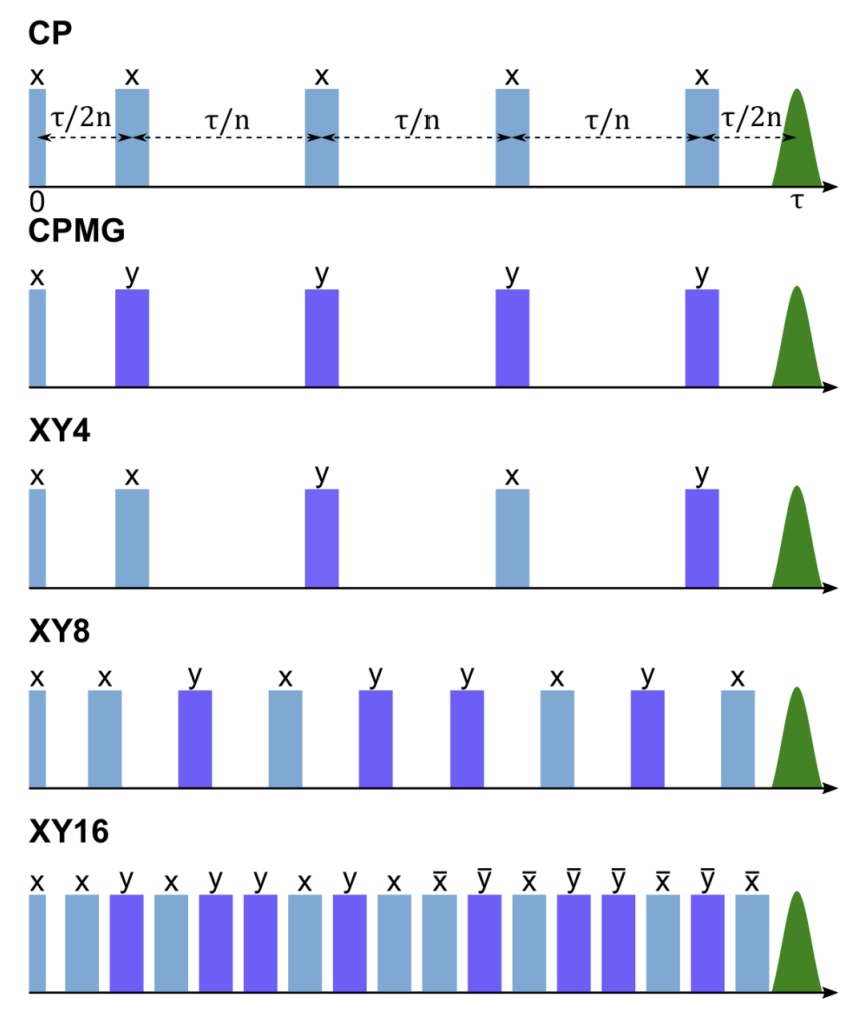

In [126]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq

In [127]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [128]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

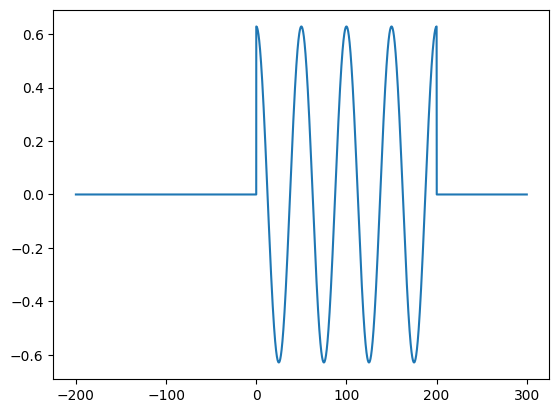

In [129]:
# resonator drive pulse simulation

tlist = np.linspace(-200, 300, 10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': 0, 'T_end_r': 200, 'Omega_rd': 2*np.pi*0.02}))

## CP CPMG UDD Sequence

In [130]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [131]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [132]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

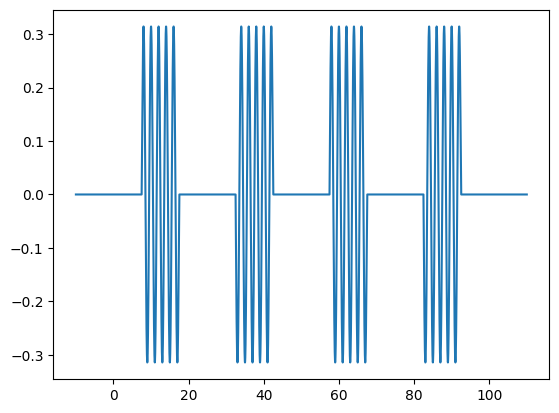

In [133]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

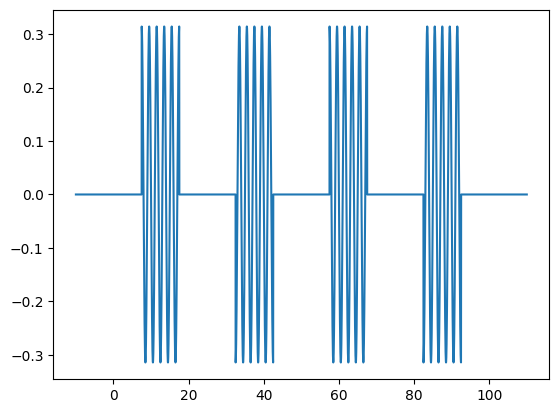

In [134]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

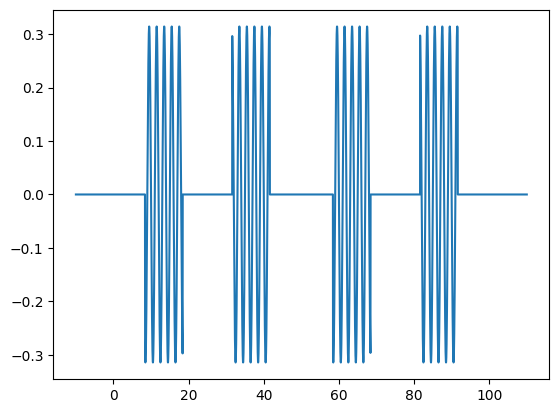

In [135]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

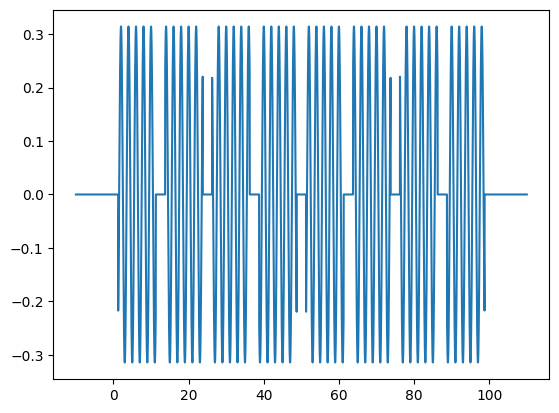

In [136]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

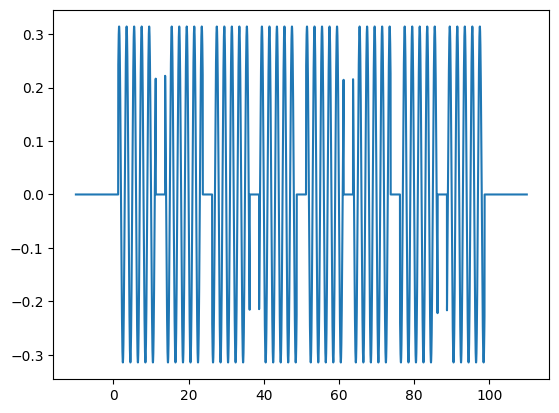

In [137]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

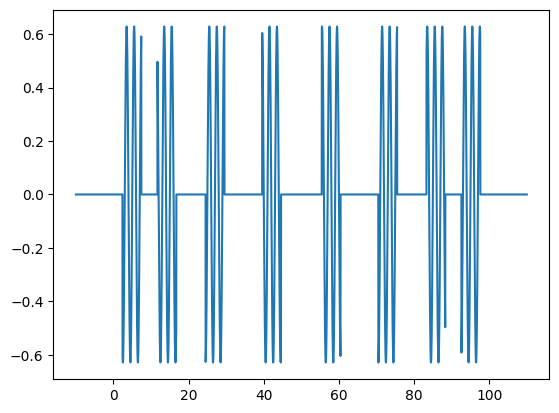

In [138]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

## XY4 XY8 XY16 Sequence

In [139]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 1.0*np.pi)

    return pulse

In [140]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 1.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 1.0*np.pi)

    return pulse

In [141]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

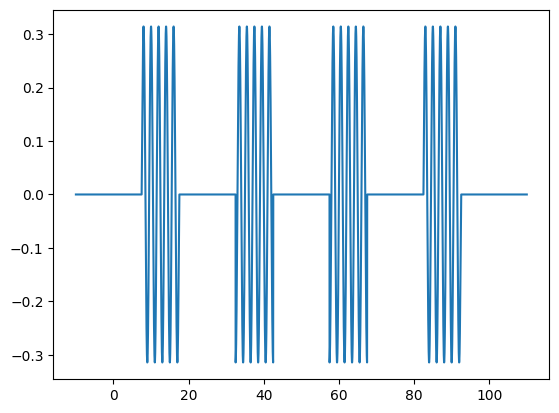

In [142]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

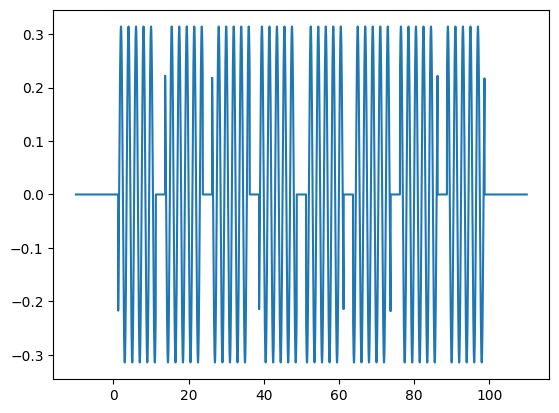

In [143]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY8_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

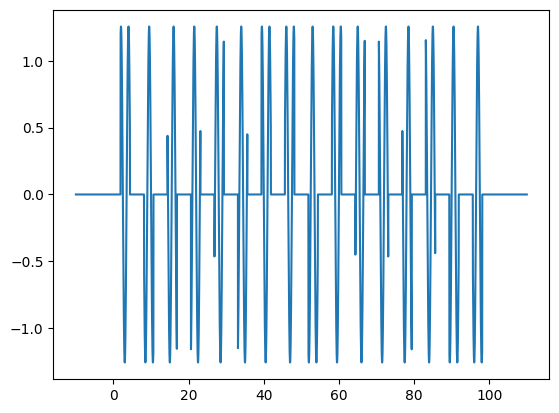

In [144]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

## UDD4 UDD8 UDD16 Sequence

In [145]:
# UDD4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [146]:
# UDD8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [147]:
# UDD16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

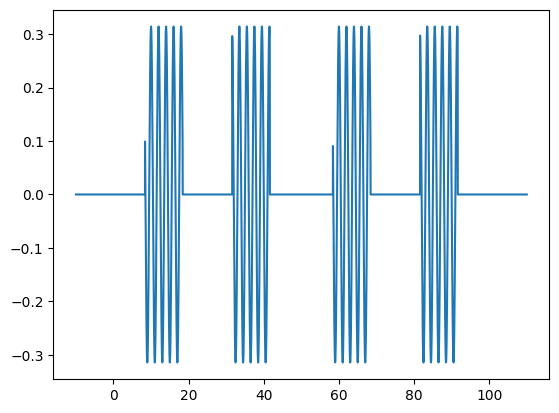

In [148]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

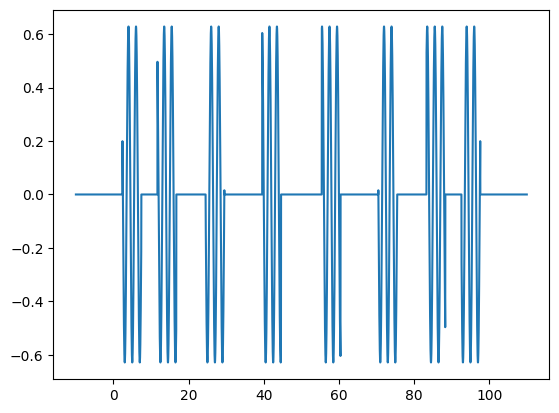

In [149]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD8_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

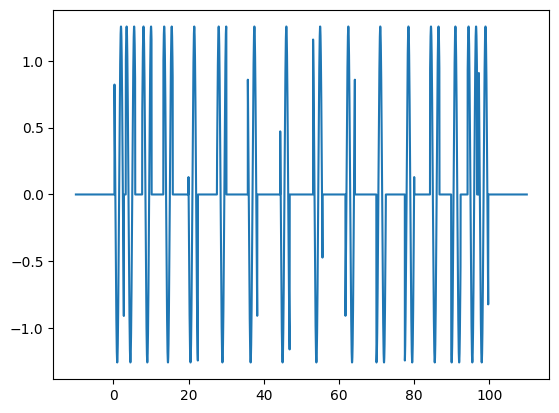

In [150]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

# Goal of this paper

Goal : Investigate the effect of dynamical decoupling

Total evolution time : 500ns, 1000ns

Condition 1 : small photon number regime $ n = 0.005 $

Condition 2 : without Purcell Filter

Ramsey    CP (N=1)    CPMG (N=1)    CP (N=2)    CPMG (N=2)

CP (N=4)    CPMG (N=4)    XY4

CP (N=8)    CPMG (N=8)    XY8

CP (N=16)    CPMG (N=16)    XY16

If only Purcell Decay Decoherence exists,

Evolution time 500ns : 0.8546

Evolution time 1000ns : 0.7304

In [268]:
sequence_1 = ['Ramsey',
 'CP(N=1)',
 'CPMG(N=1)',
 'CP(N=2)',
 'CPMG(N=2)',
 'CP(N=4)',
 'CPMG(N=4)',
 'XY4',
 'CP(N=8)',
 'CPMG(N=8)',
 'XY8',
 'CP(N=16)',
 'CPMG(N=16)',
 'XY16']

sequence_2 = ['Ramsey', 'XY4', 'XY8', 'XY16']

In [261]:
no_detune_500 = [0.8454220313189545,
 0.8427019907955158,
 0.8159472981124257,
 0.8627377320327173,
 0.8240130456767231,
 0.8373770522847371,
 0.8282382297275644,
 0.7962492271017917,
 0.8500986200963534,
 0.2743039595909242,
 0.8514428580144524,
 0.8695062625051857,
 0.3706450491992247,
 0.8447375213212501]

In [262]:
lamb_shift_detune_500 = [0.8454220313189545,
 0.8441064734549426,
 0.8401911032634553,
 0.8349663217228407,
 0.8423825127243141,
 0.8341653527728454,
 0.8543162109197089,
 0.8612884618819181,
 0.8349915465141076,
 0.8359167385528518,
 0.8396878798481398,
 0.8457292340397853,
 0.8326930232026604,
 0.8465092012849217]

In [263]:
acstark_shift_detune_500 = [0.8454220313189545,
 0.8375543789883336,
 0.8391667357049857,
 0.841981174249007,
 0.848316251621948,
 0.8519224194174377,
 0.8497782234304752,
 0.855832980429303,
 0.834168388779031,
 0.854492063612672,
 0.8404673599154904,
 0.8499599533119917,
 0.8362157851898557,
 0.8598904898803652]

In [264]:
no_detune_1000 = [0.7173163732316434,
 0.6646490762447993,
 0.7298767594988386,
 0.723293873753271,
 0.6901341552208913,
 0.755006375813557,
 0.6575722503824499,
 0.6793514544153385,
 0.673394698969722,
 0.6744837076994115,
 0.7140429999613148,
 0.7627911568575131,
 0.4916807806117807,
 0.7126399139720303]

In [265]:
lamb_shift_detune_1000 = [0.7173163732316434,
 0.723038580493172,
 0.7187845821234682,
 0.708770203072905,
 0.717430181814179,
 0.7040047918654084,
 0.7221099196979238,
 0.7230928778449953,
 0.7140958967065818,
 0.7400499817807428,
 0.7262253768692384,
 0.7314221560830617,
 0.7242988156698239,
 0.7456510045437064]

In [266]:
acstark_shift_detune_1000 = [0.7173163732316434,
 0.7208695415854021,
 0.7153812091935815,
 0.7511519186825933,
 0.724914063092199,
 0.7034849868333004,
 0.7228969408563841,
 0.7237160554633462,
 0.7025769544215161,
 0.7414480014506121,
 0.7231386762032895,
 0.7217901309715937,
 0.724589823836723,
 0.7375327288585853]

Text(0, 0.5, 'Coherence')

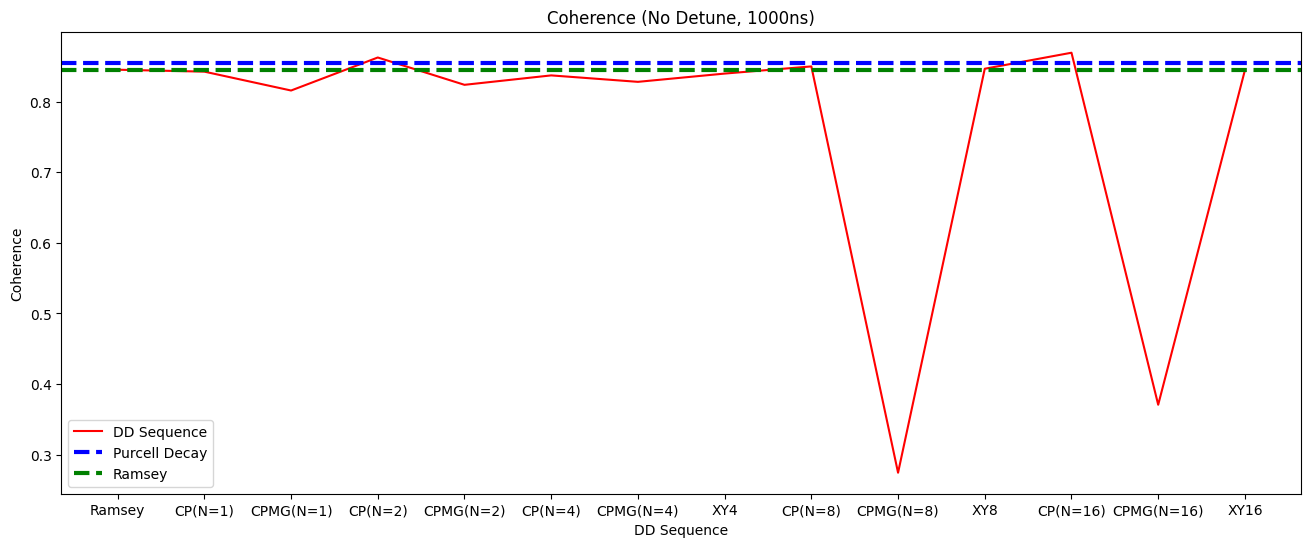

In [283]:
# Plot Results
plt.figure(figsize=(16,6))

plt.plot(sequence_1, no_detune_500, label = 'DD Sequence', color='red')
plt.axhline(0.8546, 0, 1, color='blue', linestyle='--', linewidth=3, label = 'Purcell Decay')
plt.axhline(no_detune_500[0], 0, 1, color='green', linestyle='--', linewidth=3, label = 'Ramsey')

plt.legend()
plt.title('Coherence (No Detune, 1000ns)')
plt.xlabel('DD Sequence')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

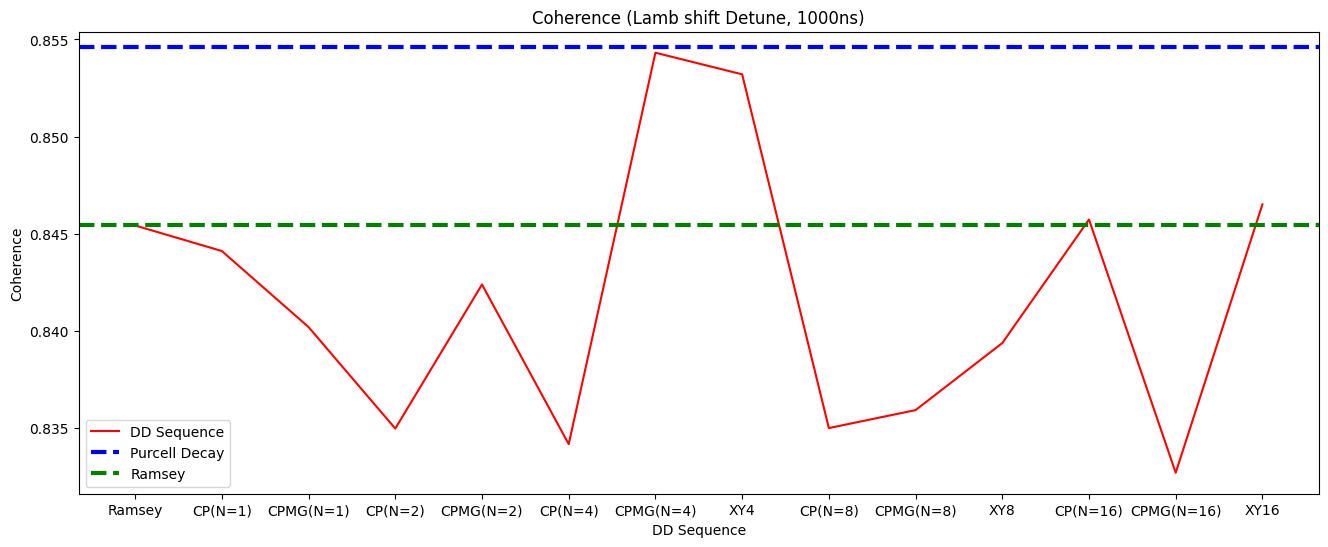

In [284]:
# Plot Results
plt.figure(figsize=(16,6))

plt.plot(sequence_1, lamb_shift_detune_500, label = 'DD Sequence', color='red')
plt.axhline(0.8546, 0, 1, color='blue', linestyle='--', linewidth=3, label = 'Purcell Decay')
plt.axhline(lamb_shift_detune_500[0], 0, 1, color='green', linestyle='--', linewidth=3, label = 'Ramsey')

plt.legend()
plt.title('Coherence (Lamb shift Detune, 1000ns)')
plt.xlabel('DD Sequence')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

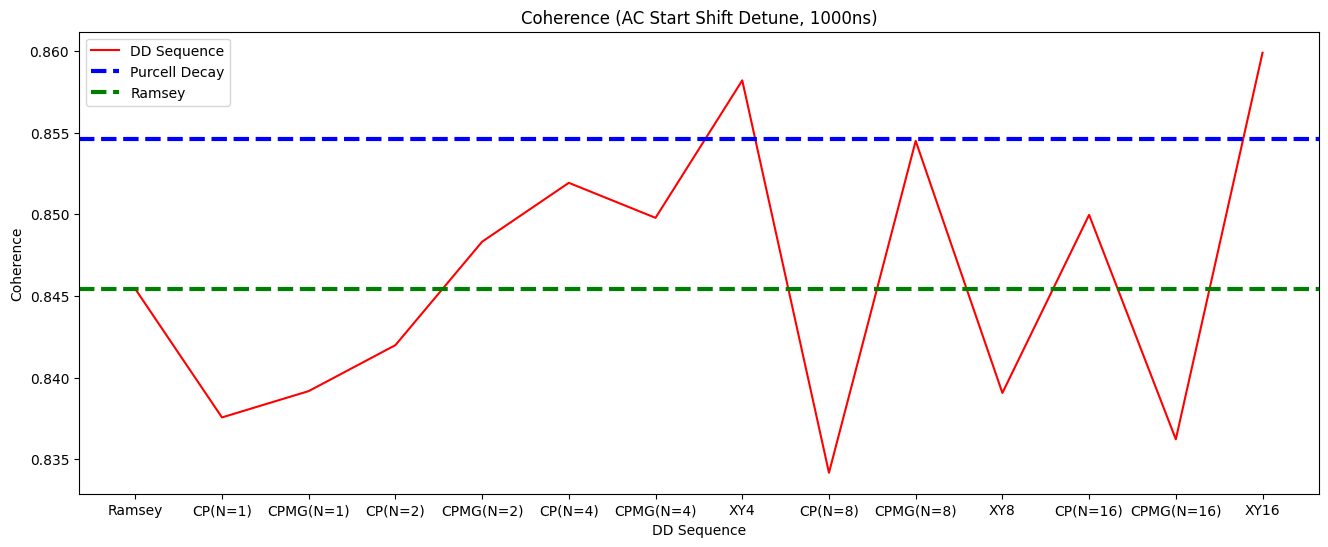

In [286]:
# Plot Results
plt.figure(figsize=(16,6))

plt.plot(sequence_1, acstark_shift_detune_500, label = 'DD Sequence', color='red')
plt.axhline(0.8546, 0, 1, color='blue', linestyle='--', linewidth=3, label = 'Purcell Decay')
plt.axhline(acstark_shift_detune_500[0], 0, 1, color='green', linestyle='--', linewidth=3, label = 'Ramsey')

plt.legend()
plt.title('Coherence (AC Start Shift Detune, 1000ns)')
plt.xlabel('DD Sequence')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

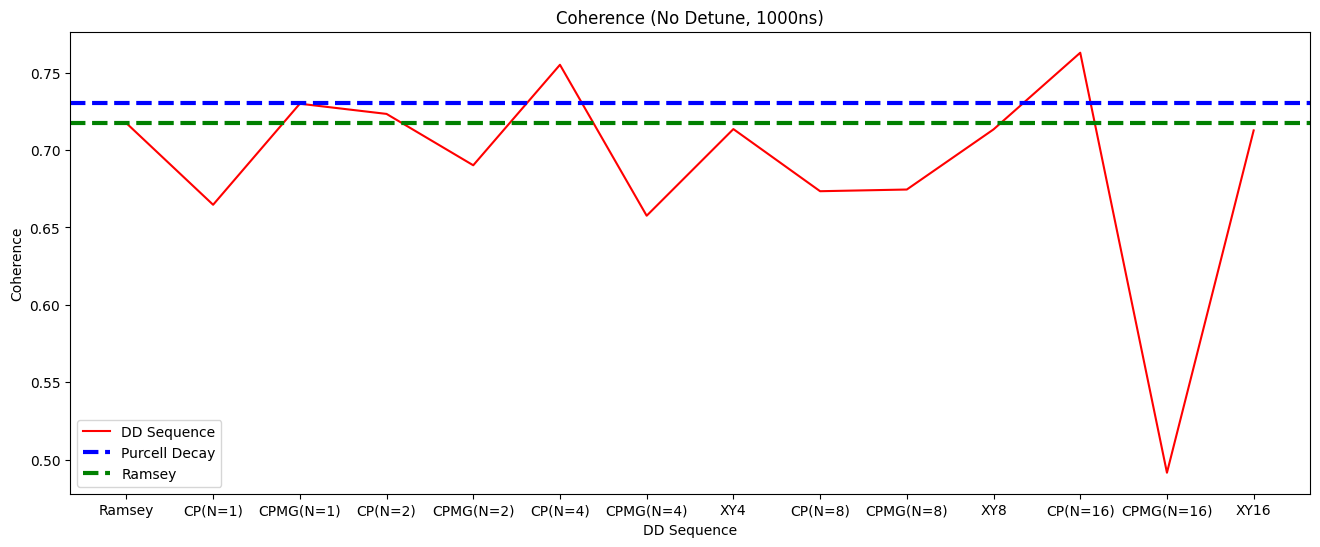

In [280]:
# Plot Results
plt.figure(figsize=(16,6))

plt.plot(sequence_1, lamb_shift_detune_1000, label = 'DD Sequence', color='red')
plt.axhline(0.7304, 0, 1, color='blue', linestyle='--', linewidth=3, label = 'Purcell Decay')
plt.axhline(lamb_shift_detune_1000[0], 0, 1, color='green', linestyle='--', linewidth=3, label = 'Ramsey')

plt.legend()
plt.title('Coherence (No Detune, 1000ns)')
plt.xlabel('DD Sequence')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

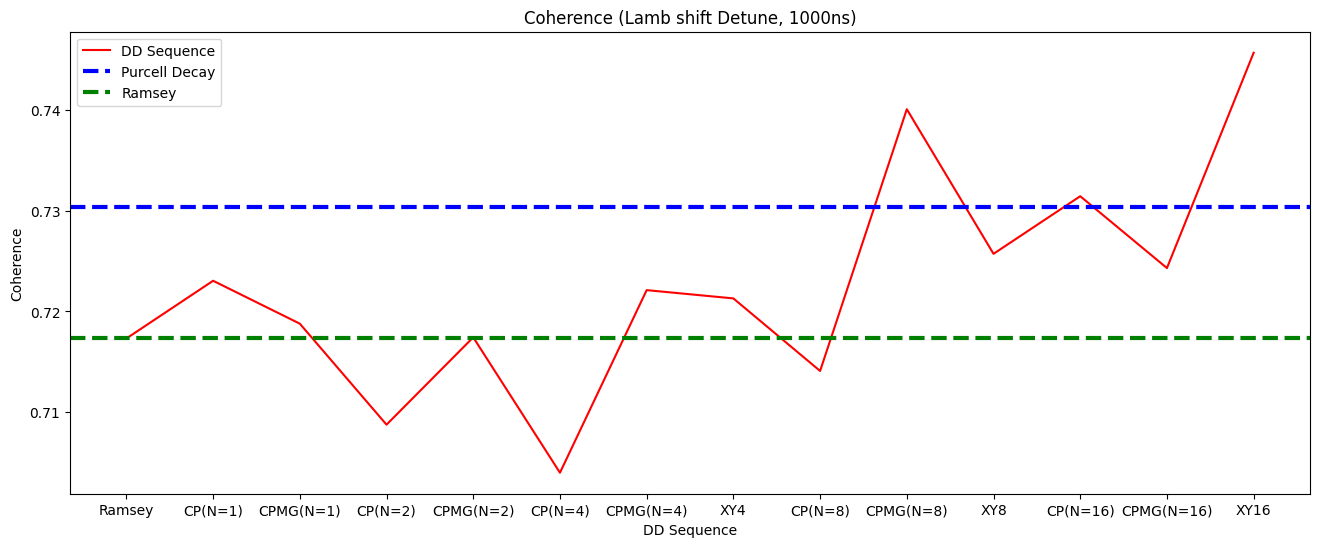

In [281]:
# Plot Results
plt.figure(figsize=(16,6))

plt.plot(sequence_1, lamb_shift_detune_1000, label = 'DD Sequence', color='red')
plt.axhline(0.7304, 0, 1, color='blue', linestyle='--', linewidth=3, label = 'Purcell Decay')
plt.axhline(lamb_shift_detune_1000[0], 0, 1, color='green', linestyle='--', linewidth=3, label = 'Ramsey')

plt.legend()
plt.title('Coherence (Lamb shift Detune, 1000ns)')
plt.xlabel('DD Sequence')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

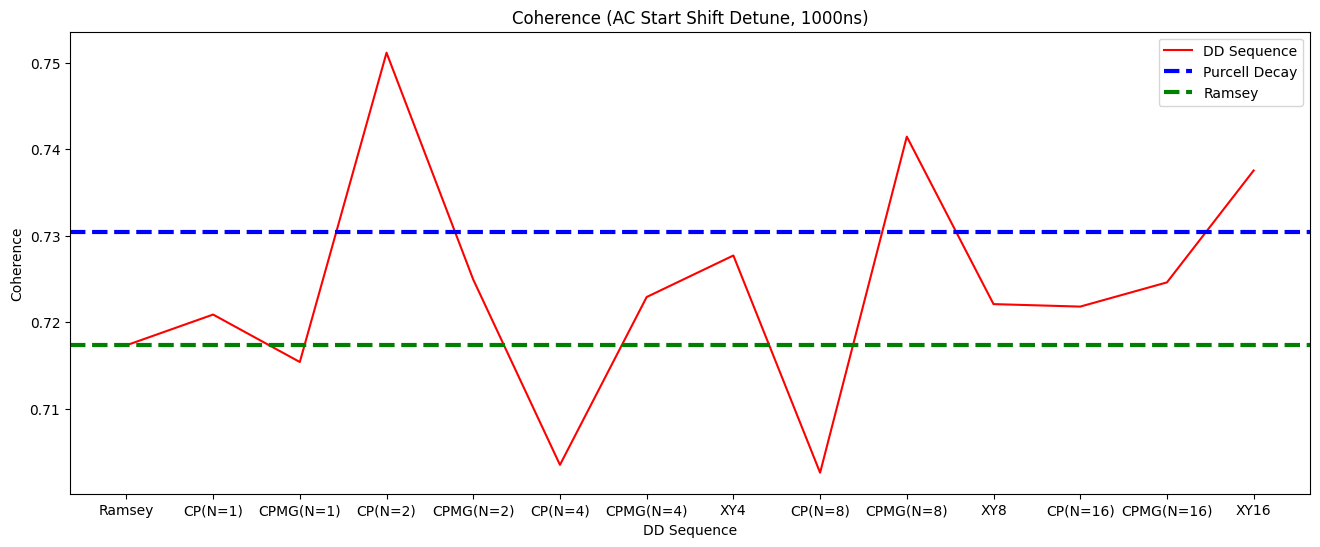

In [282]:
# Plot Results
plt.figure(figsize=(16,6))

plt.plot(sequence_1, acstark_shift_detune_1000, label = 'DD Sequence', color='red')
plt.axhline(0.7304, 0, 1, color='blue', linestyle='--', linewidth=3, label = 'Purcell Decay')
plt.axhline(acstark_shift_detune_1000[0], 0, 1, color='green', linestyle='--', linewidth=3, label = 'Ramsey')

plt.legend()
plt.title('Coherence (AC Start Shift Detune, 1000ns)')
plt.xlabel('DD Sequence')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

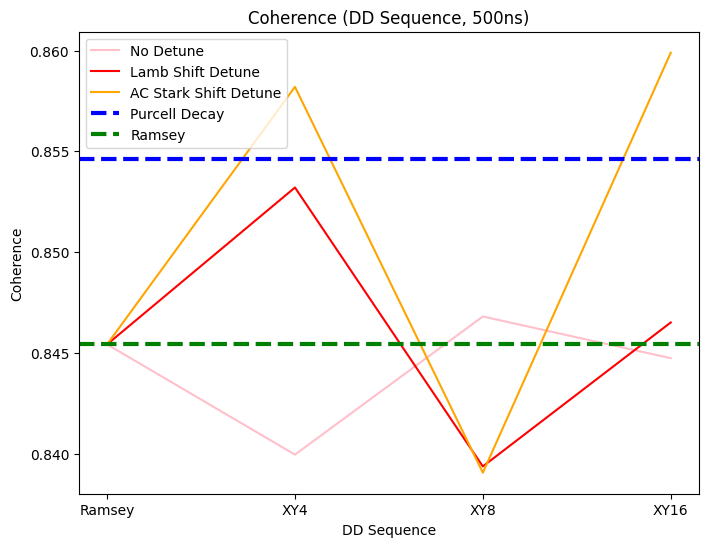

In [290]:
# Plot Results
plt.figure(figsize=(8,6))

plt.plot(sequence_2, np.array([no_detune_500[0], no_detune_500[7], no_detune_500[10], no_detune_500[13]]), label = 'No Detune', color='pink')
plt.plot(sequence_2, np.array([lamb_shift_detune_500[0], lamb_shift_detune_500[7], lamb_shift_detune_500[10], lamb_shift_detune_500[13]]), label = 'Lamb Shift Detune', color='red')
plt.plot(sequence_2, np.array([acstark_shift_detune_500[0], acstark_shift_detune_500[7], acstark_shift_detune_500[10], acstark_shift_detune_500[13]]), label = 'AC Stark Shift Detune', color='orange')

plt.axhline(0.8546, 0, 1, color='blue', linestyle='--', linewidth=3, label = 'Purcell Decay')
plt.axhline(acstark_shift_detune_500[0], 0, 1, color='green', linestyle='--', linewidth=3, label = 'Ramsey')

plt.legend()
plt.title('Coherence (DD Sequence, 500ns)')
plt.xlabel('DD Sequence')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

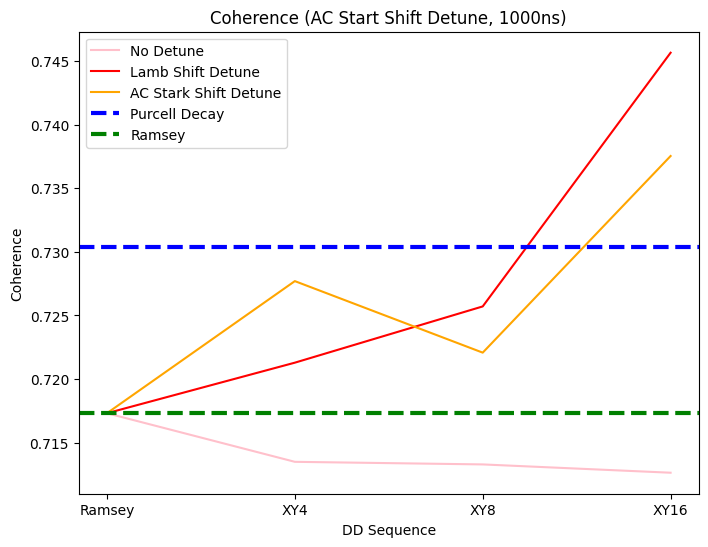

In [289]:
# Plot Results
plt.figure(figsize=(8,6))

plt.plot(sequence_2, np.array([no_detune_1000[0], no_detune_1000[7], no_detune_1000[10], no_detune_1000[13]]), label = 'No Detune', color='pink')
plt.plot(sequence_2, np.array([lamb_shift_detune_1000[0], lamb_shift_detune_1000[7], lamb_shift_detune_1000[10], lamb_shift_detune_1000[13]]), label = 'Lamb Shift Detune', color='red')
plt.plot(sequence_2, np.array([acstark_shift_detune_1000[0], acstark_shift_detune_1000[7], acstark_shift_detune_1000[10], acstark_shift_detune_1000[13]]), label = 'AC Stark Shift Detune', color='orange')

plt.axhline(0.7304, 0, 1, color='blue', linestyle='--', linewidth=3, label = 'Purcell Decay')
plt.axhline(acstark_shift_detune_1000[0], 0, 1, color='green', linestyle='--', linewidth=3, label = 'Ramsey')

plt.legend()
plt.title('Coherence (DD Sequence, 1000ns)')
plt.xlabel('DD Sequence')
plt.ylabel('Coherence')

# Dynamical Decoupling Simulation

$ \omega_{qd} = \omega_q^b $

Evolution time 500ns

In [233]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 5000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.0002 * 2 * np.pi
B = 0.1 * 2 * np.pi

coherence_list = []

## Ramsey

In [61]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.004467045283937603


Text(0, 0.5, 'Z Expectation Value')

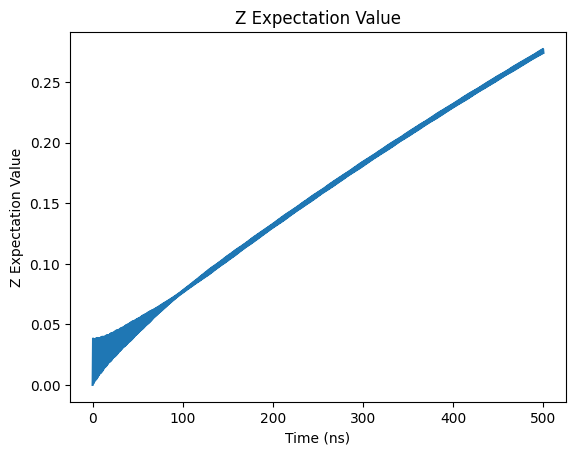

In [62]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [63]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.65284996e-01,  9.84408403e-01,  1.61692925e+03])

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

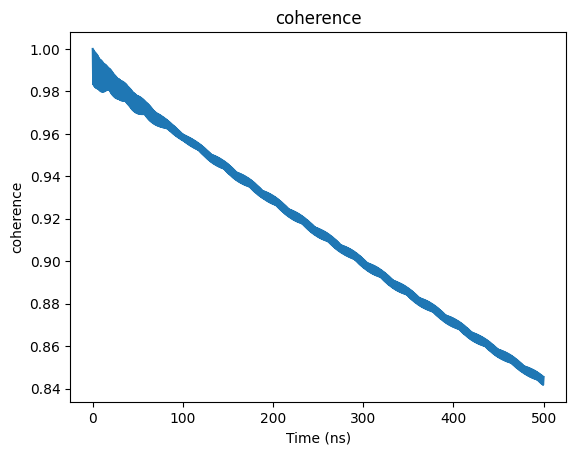

In [64]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

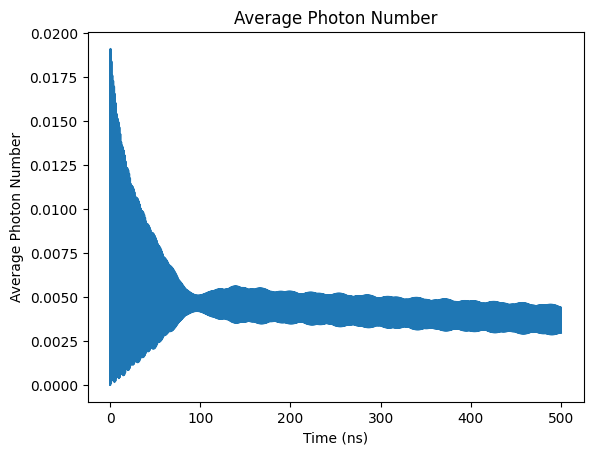

In [65]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

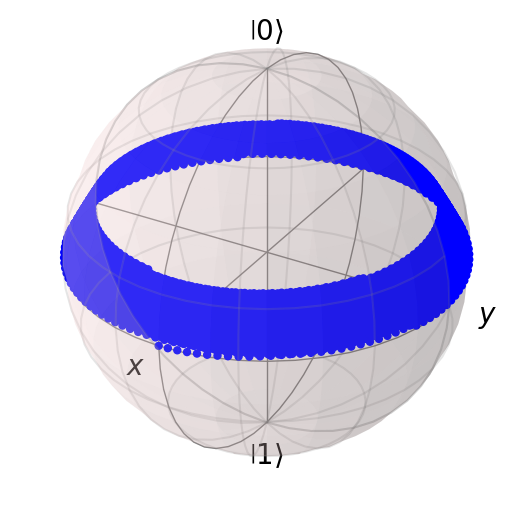

In [66]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [67]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=1)

In [68]:
# Simulation

N_seq = 1

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005155376613461142


Text(0, 0.5, 'Z Expectation Value')

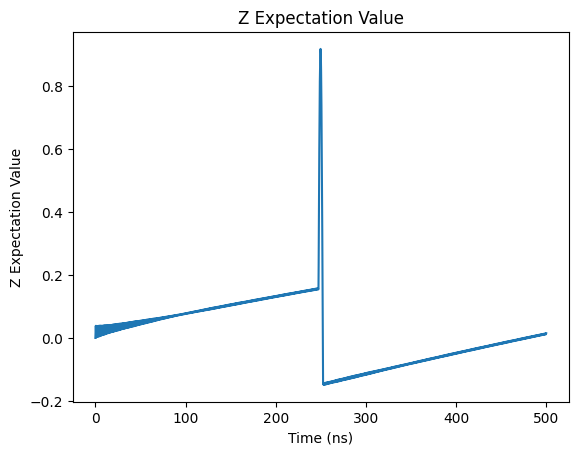

In [69]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

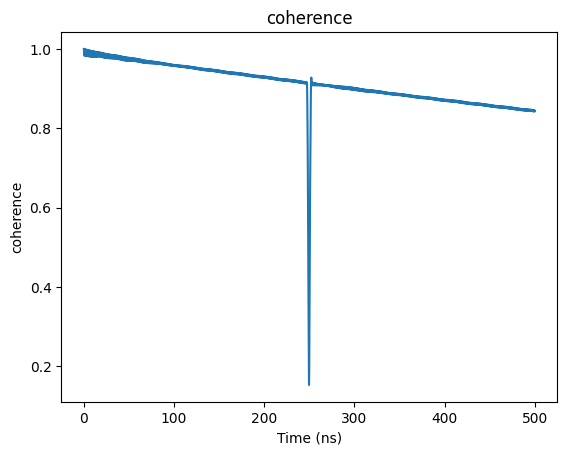

In [70]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

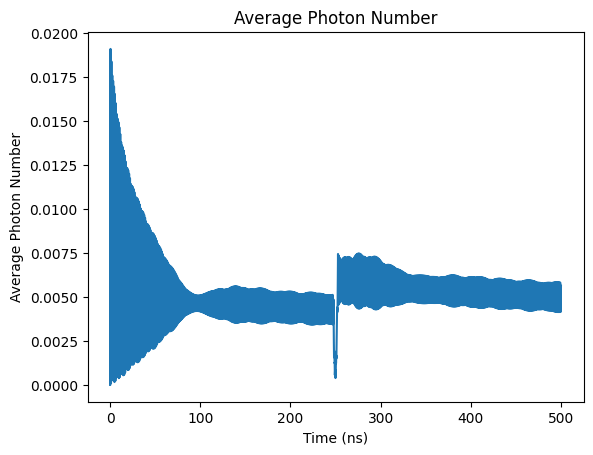

In [71]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

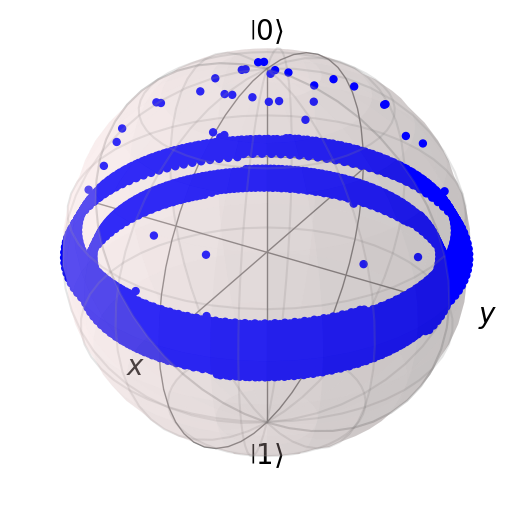

In [72]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [73]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=1)

In [74]:
N_seq = 1


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005465707967644548


Text(0, 0.5, 'Z Expectation Value')

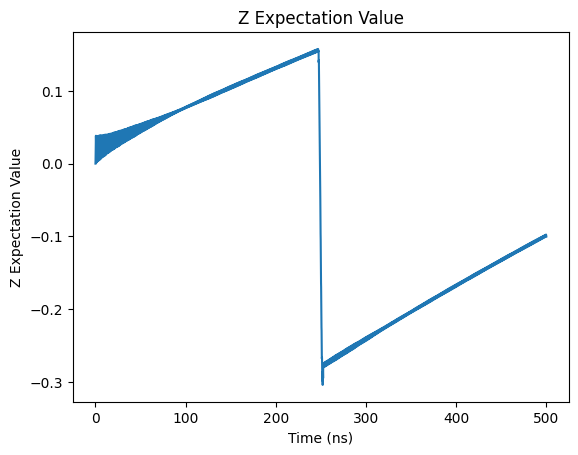

In [75]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

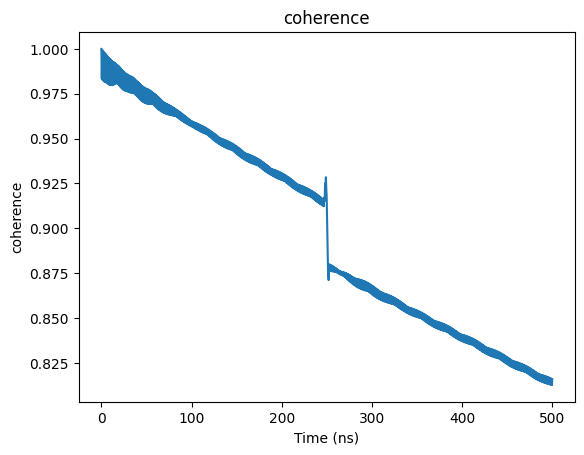

In [76]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

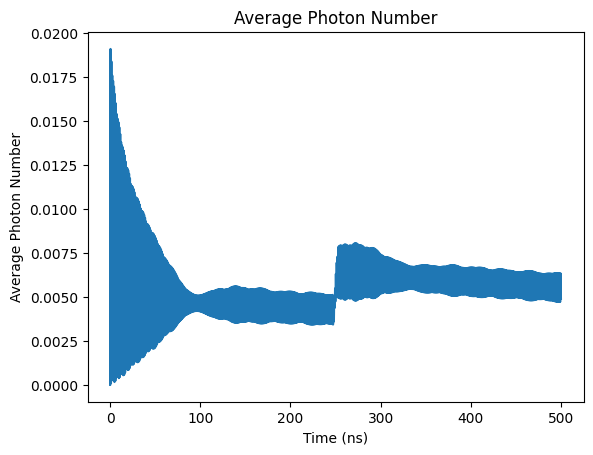

In [77]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

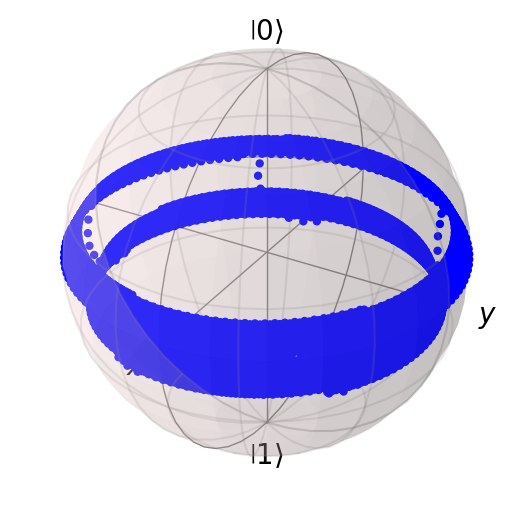

In [78]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [79]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=2)

In [80]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.0048613573653790865


Text(0, 0.5, 'Z Expectation Value')

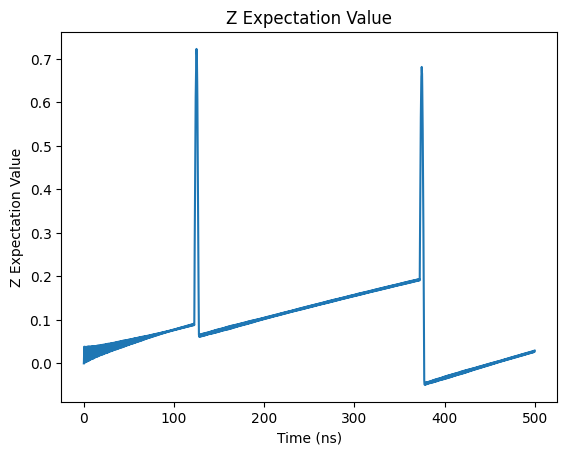

In [81]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

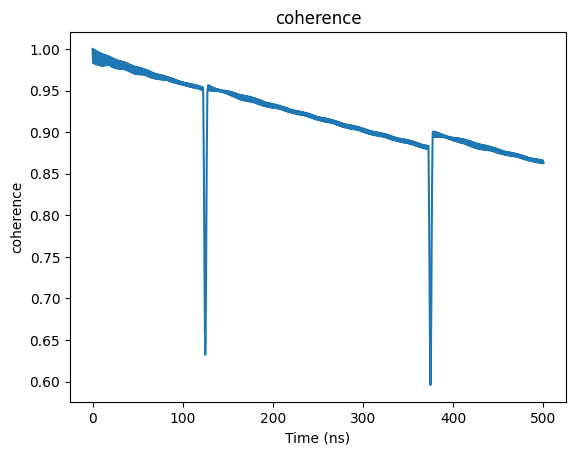

In [82]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

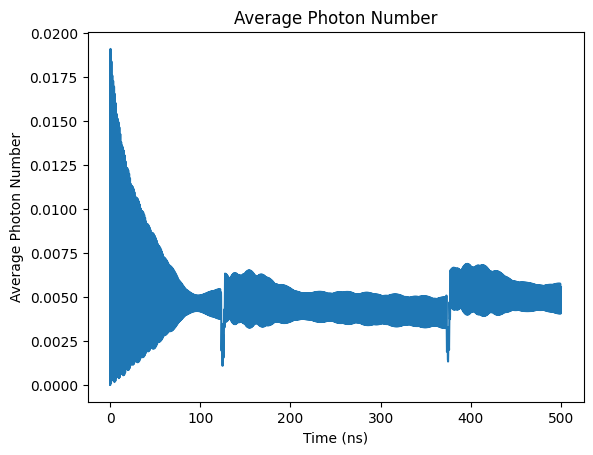

In [83]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

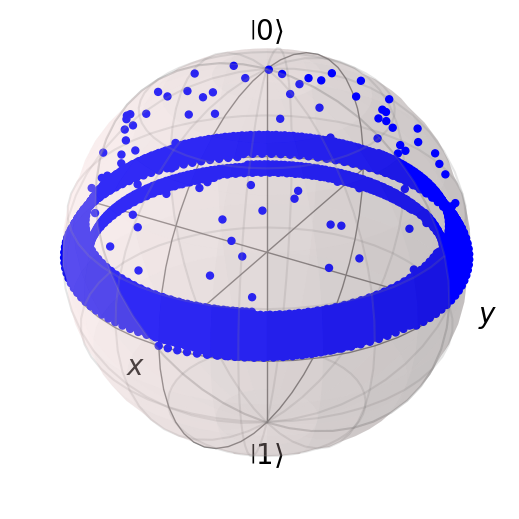

In [84]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [85]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=2)

In [86]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.0051988598332877315


Text(0, 0.5, 'Z Expectation Value')

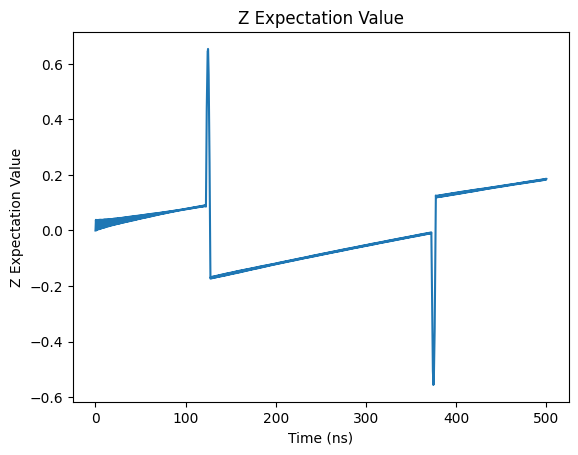

In [87]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

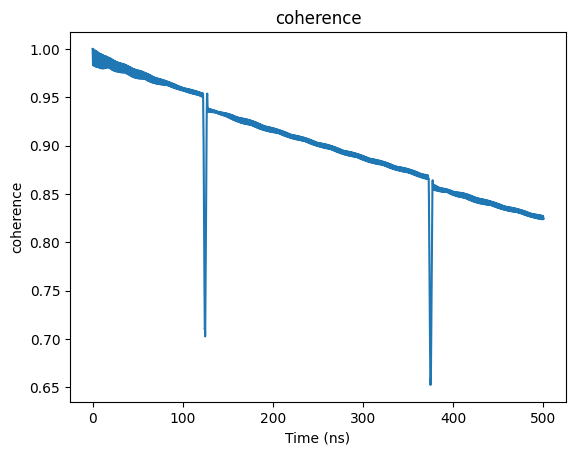

In [88]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

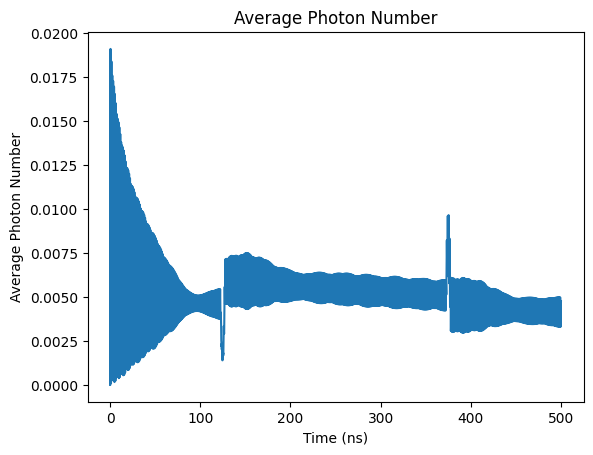

In [89]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

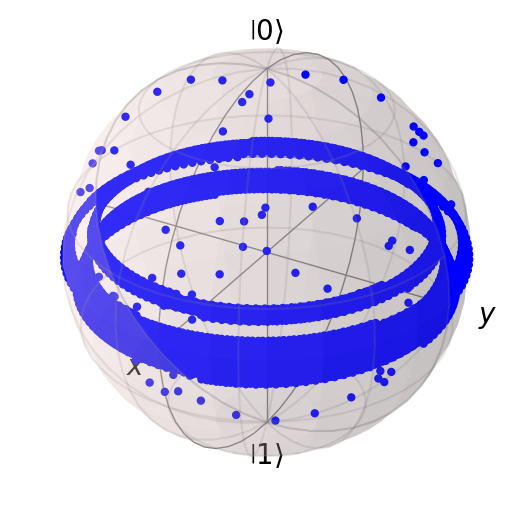

In [90]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [91]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=4)

In [92]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005606866507088636


Text(0, 0.5, 'Z Expectation Value')

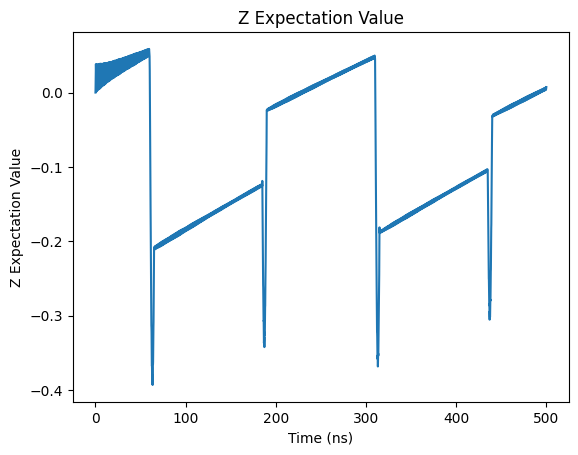

In [93]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

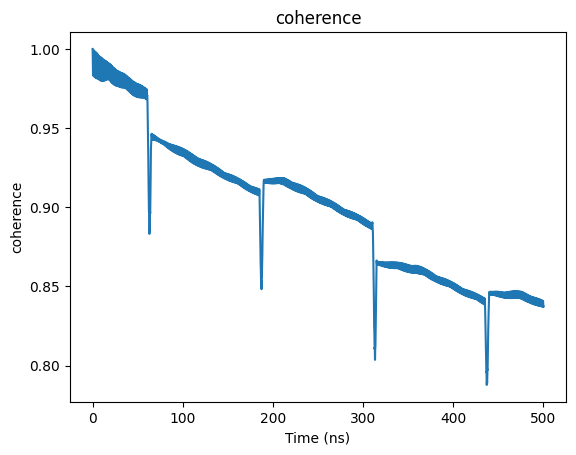

In [94]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

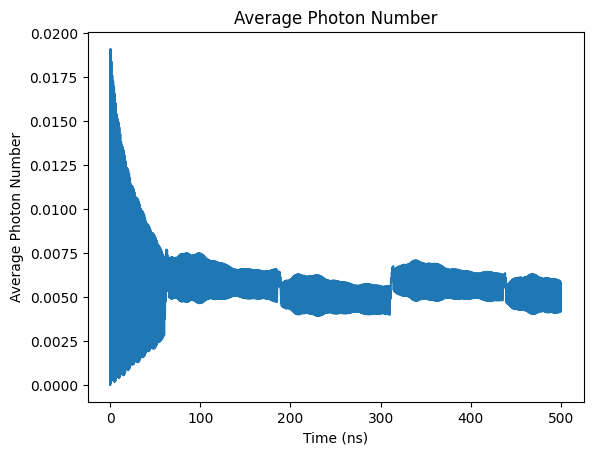

In [95]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

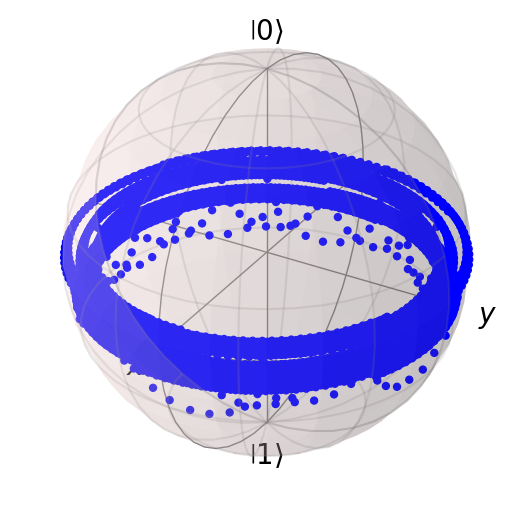

In [96]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [97]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=4)

In [98]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005218014644240749


Text(0, 0.5, 'Z Expectation Value')

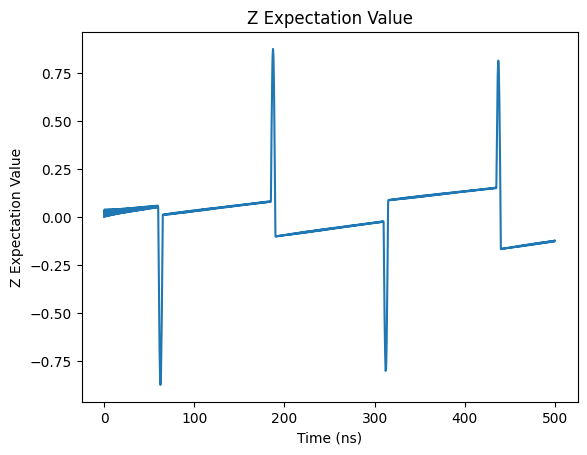

In [99]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

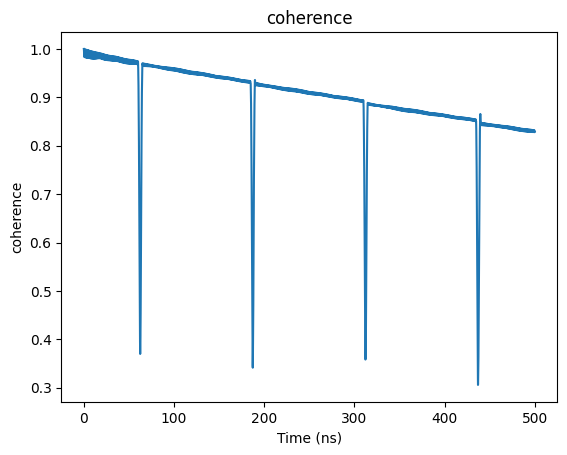

In [100]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

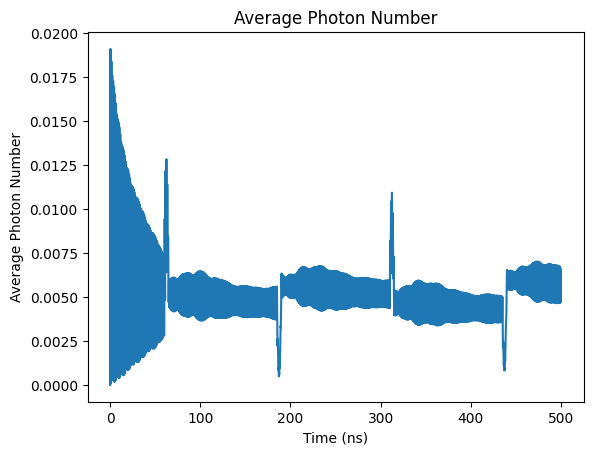

In [101]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

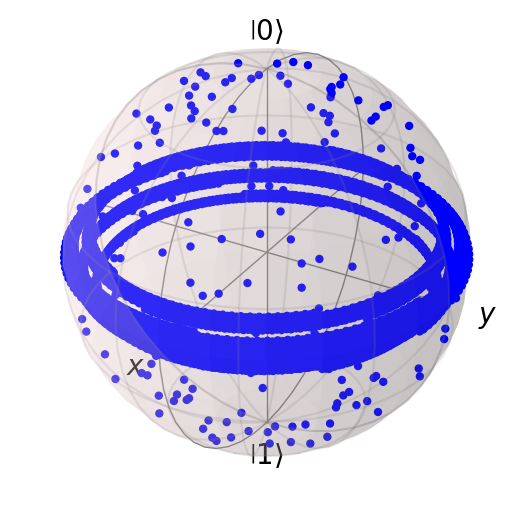

In [102]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [103]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY4

In [234]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005243232844817739


Text(0, 0.5, 'Z Expectation Value')

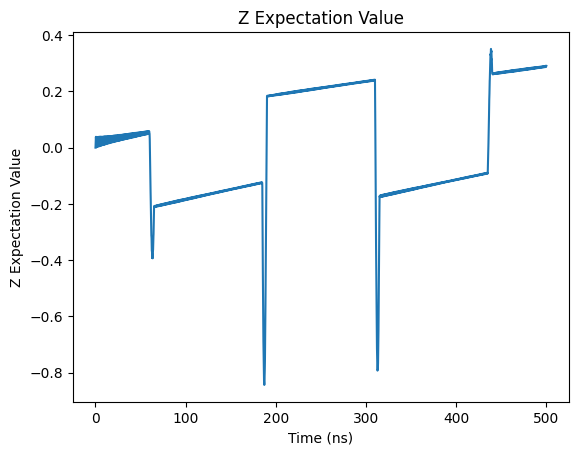

In [235]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

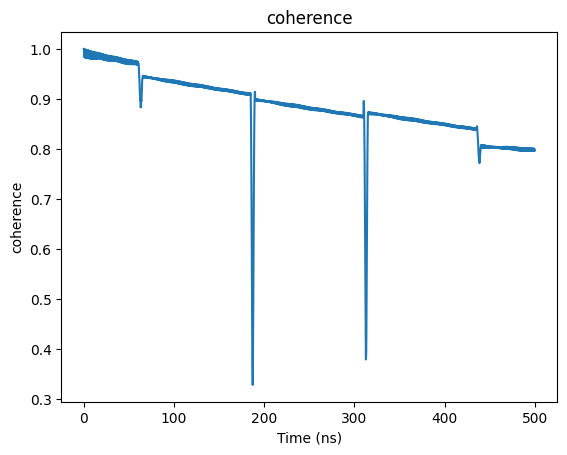

In [236]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

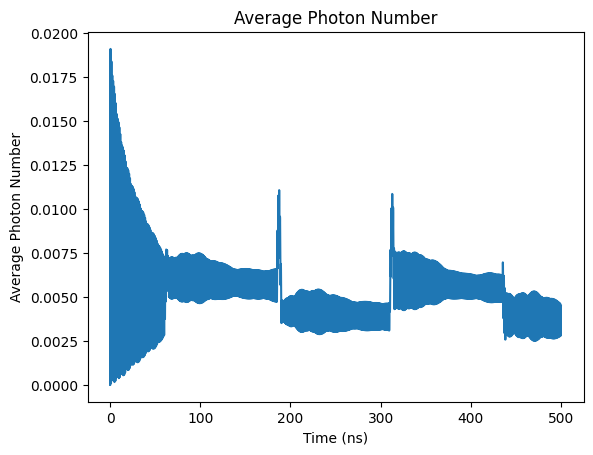

In [237]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

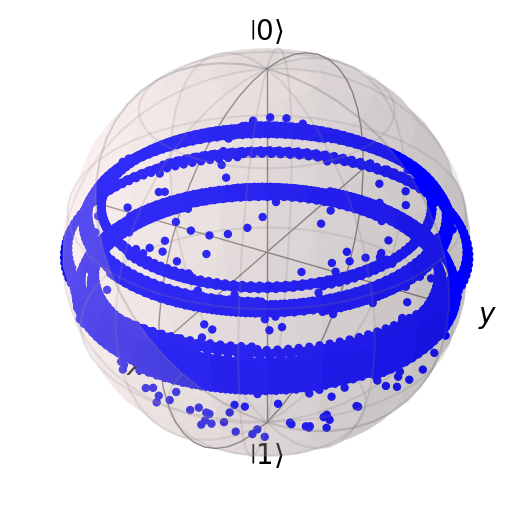

In [238]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [239]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=8)

In [110]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005085992726841968


Text(0, 0.5, 'Z Expectation Value')

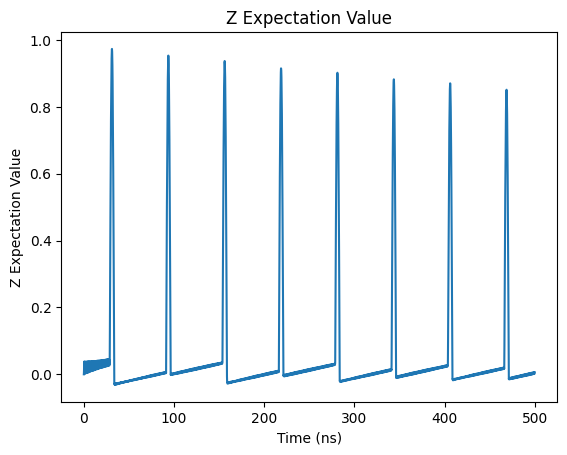

In [111]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

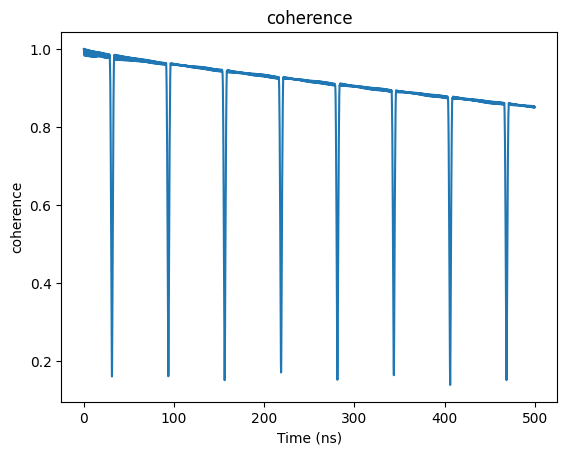

In [112]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

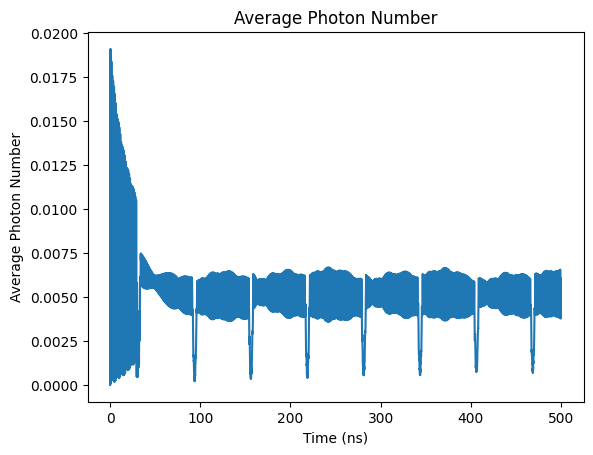

In [113]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

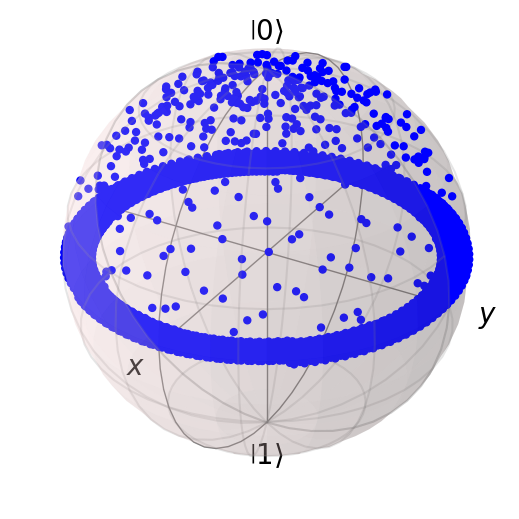

In [114]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [115]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=8)

In [116]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

KeyboardInterrupt: 

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY8

In [240]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005248525907377771


Text(0, 0.5, 'Z Expectation Value')

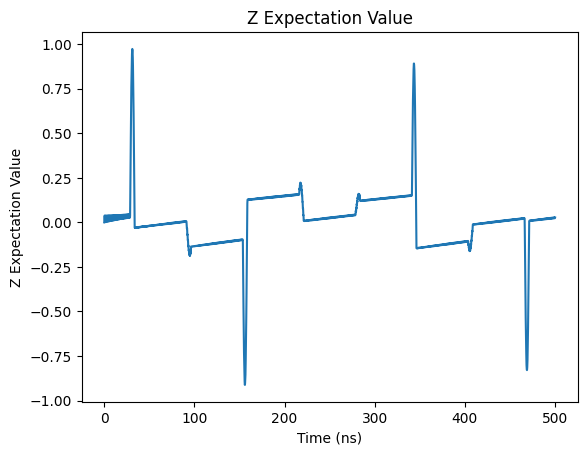

In [241]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

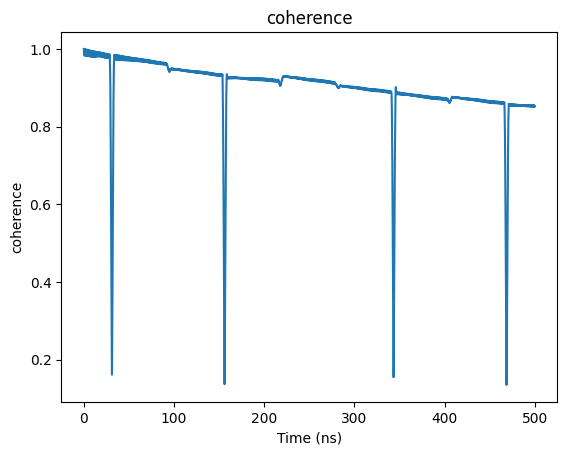

In [242]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

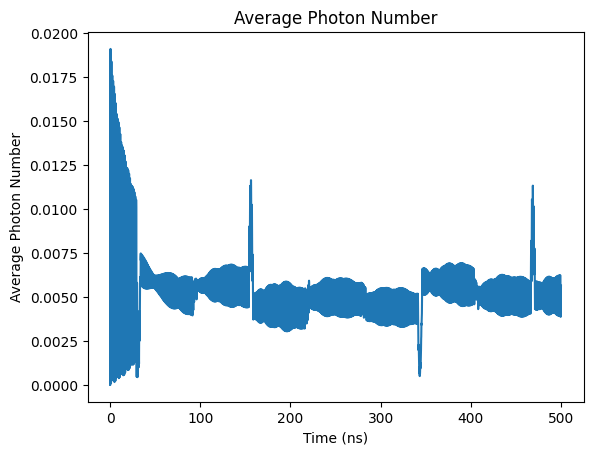

In [243]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

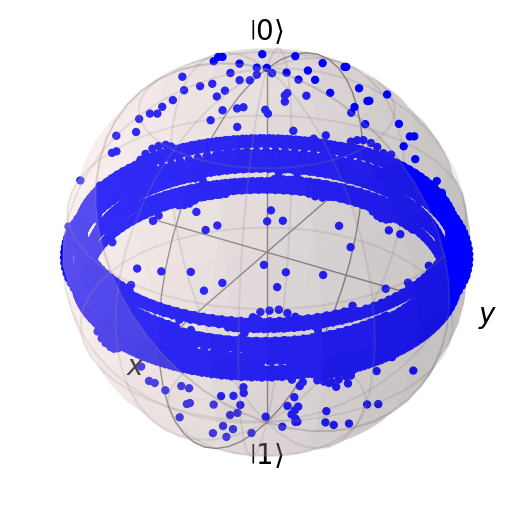

In [244]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [245]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## Print Coherence

In [246]:
coherence_list

[0.7962492271017917, 0.8514428580144524]

# Dynamical Decoupling Simulation

$ \omega_{qd} = \omega_q^b + \chi $

Evolution time 500ns

In [247]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q + chi      # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 5000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.0002 * 2 * np.pi
B = 0.1 * 2 * np.pi

coherence_list = []

## Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=1)

In [ ]:
# Simulation

N_seq = 1

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=1)

In [ ]:
N_seq = 1


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY4

In [248]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005191950933818625


Text(0, 0.5, 'Z Expectation Value')

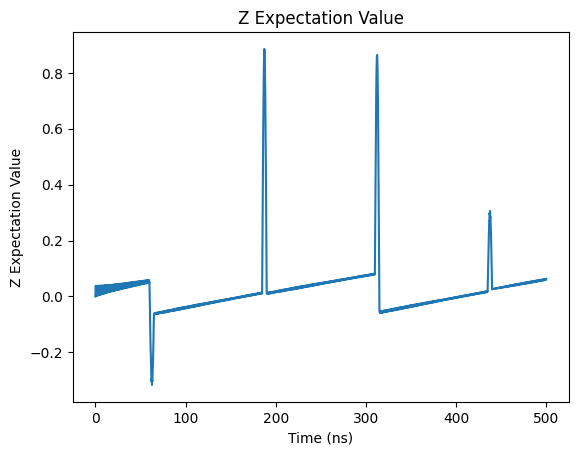

In [249]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

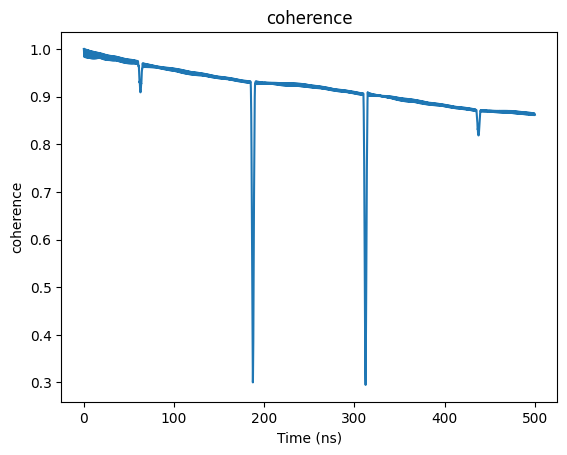

In [250]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

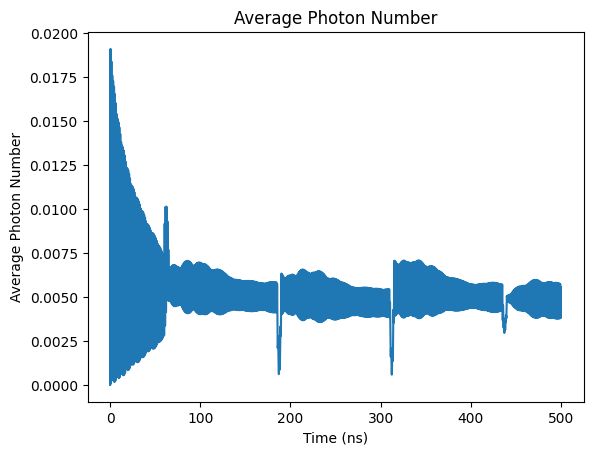

In [251]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

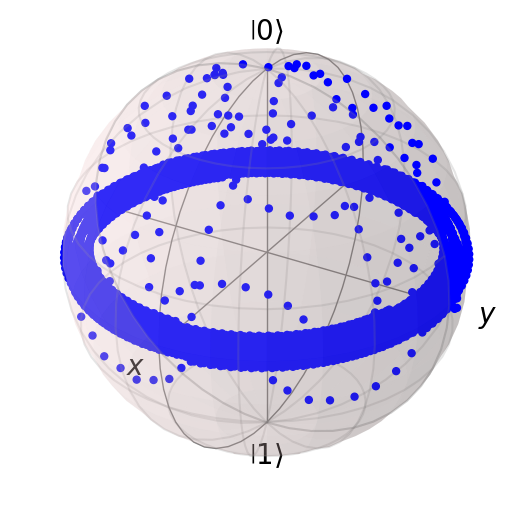

In [252]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [253]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY8

In [254]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005254768208325919


Text(0, 0.5, 'Z Expectation Value')

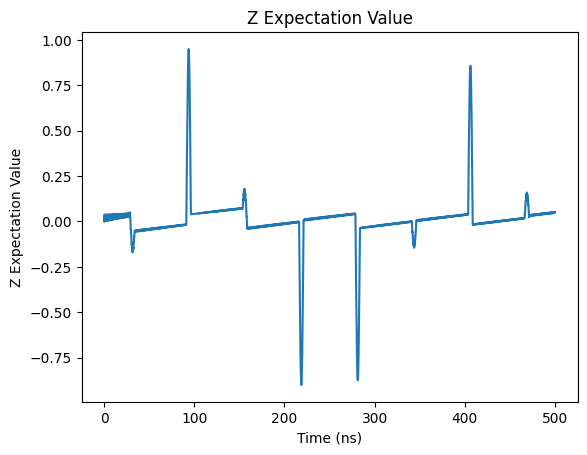

In [255]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

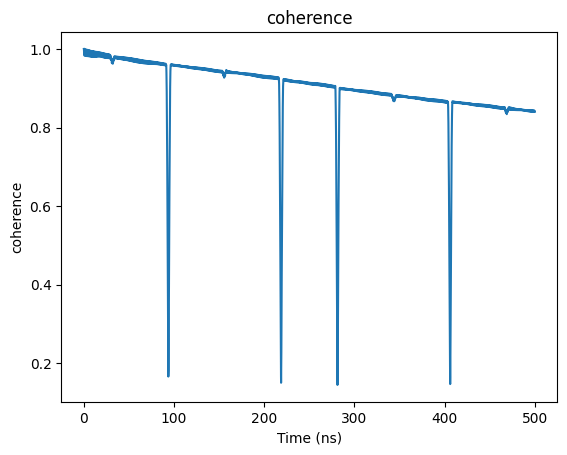

In [256]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

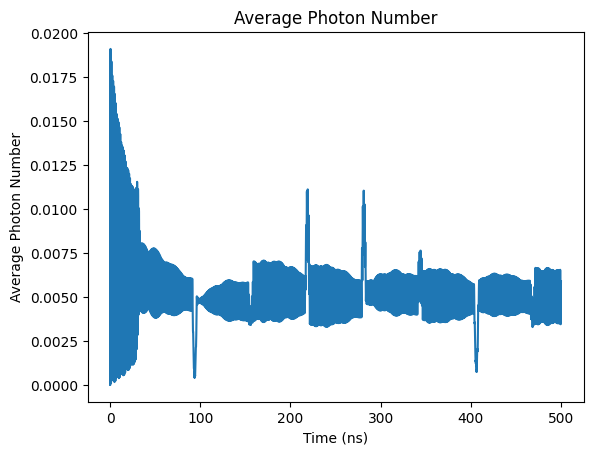

In [257]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

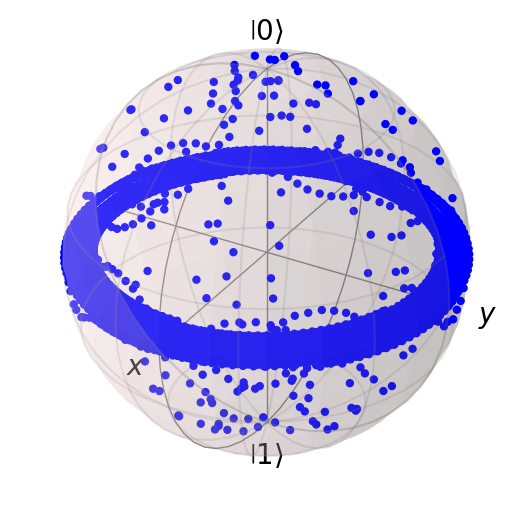

In [258]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [259]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## Print Coherence

In [260]:
coherence_list

[0.8612884618819181, 0.8396878798481398]

# Dynamical Decoupling Simulation

$ \omega_{qd} = \omega_q^b + 2n\chi $

Evolution time 500ns

In [177]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q + chi + 2*0.005*chi     # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 5000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.0002 * 2 * np.pi
B = 0.1 * 2 * np.pi

coherence_list = []

## Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=1)

In [ ]:
# Simulation

N_seq = 1

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=1)

In [ ]:
N_seq = 1


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY4

In [178]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005196718718850119


Text(0, 0.5, 'Z Expectation Value')

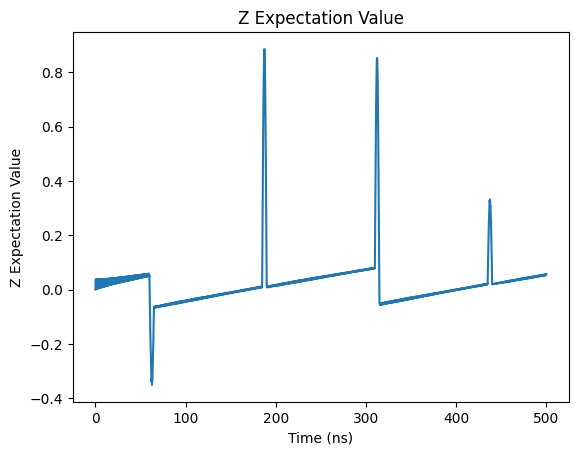

In [179]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

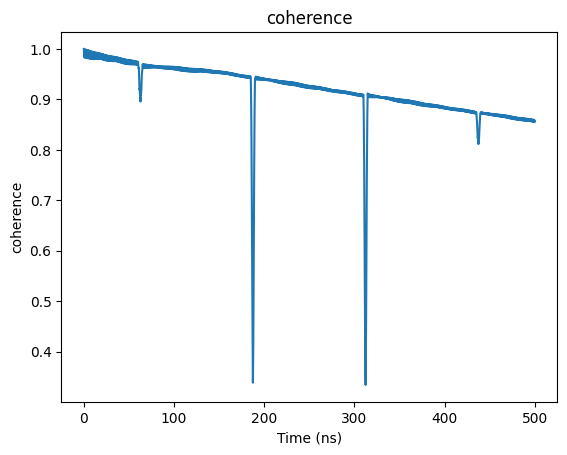

In [180]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

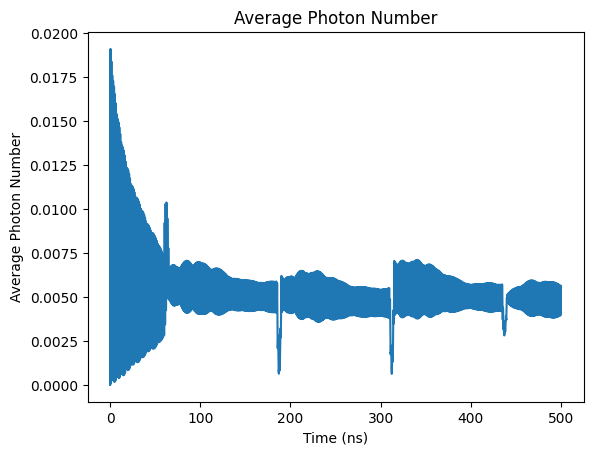

In [181]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

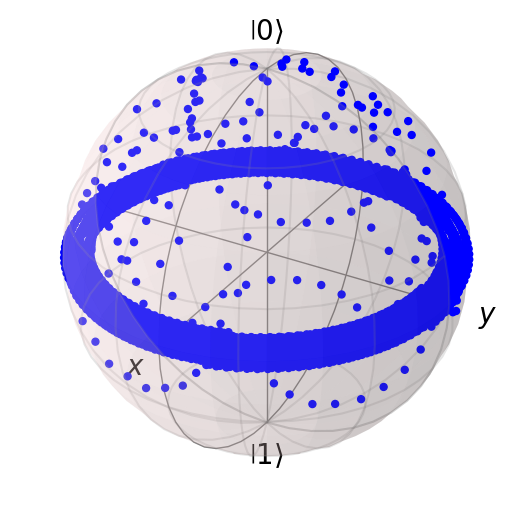

In [182]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [183]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY8

In [184]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.0052563402168221895


Text(0, 0.5, 'Z Expectation Value')

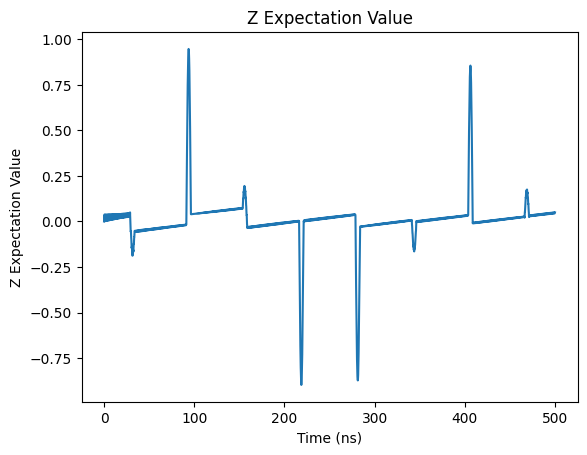

In [185]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

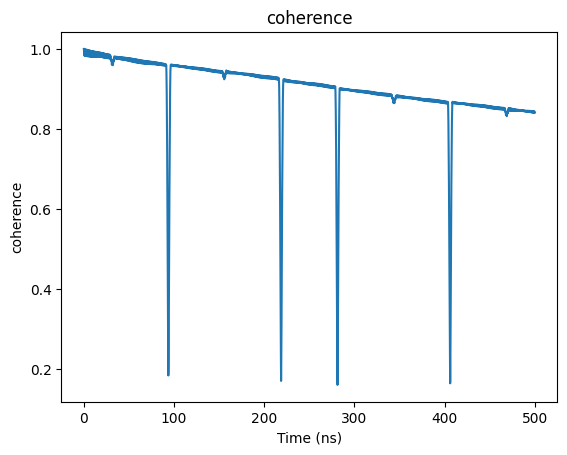

In [186]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

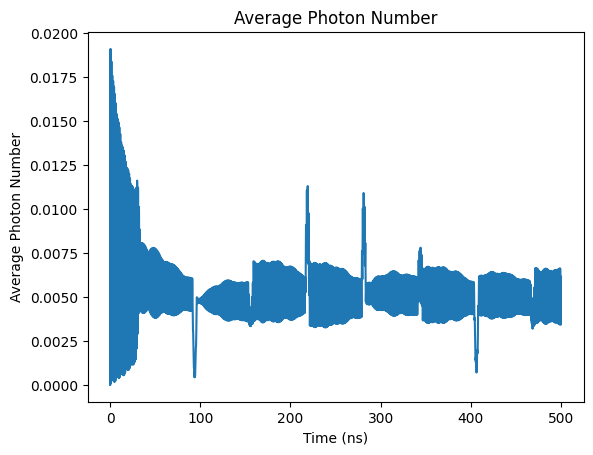

In [187]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

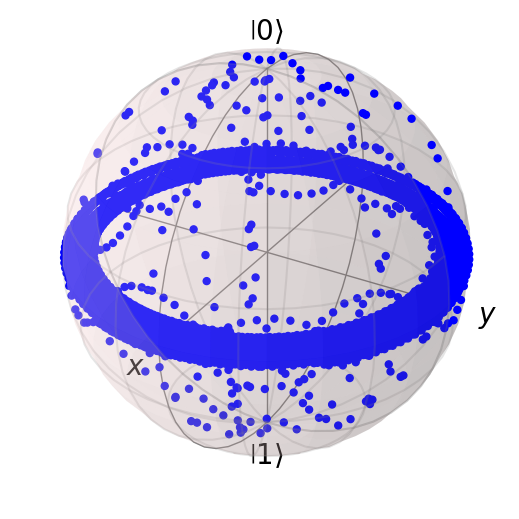

In [188]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [189]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## Print Coherence

In [190]:
coherence_list

[0.855832980429303, 0.8404673599154904]

# Dynamical Decoupling Simulation

$ \omega_{qd} = \omega_q^b $

Evolution time 1000ns

In [191]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 1000, 10000)
T_end_q = 1000

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.0002 * 2 * np.pi
B = 0.1 * 2 * np.pi

coherence_list = []

## Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=1)

In [ ]:
# Simulation

N_seq = 1

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=1)

In [ ]:
N_seq = 1


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY4

In [192]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005162182570803384


Text(0, 0.5, 'Z Expectation Value')

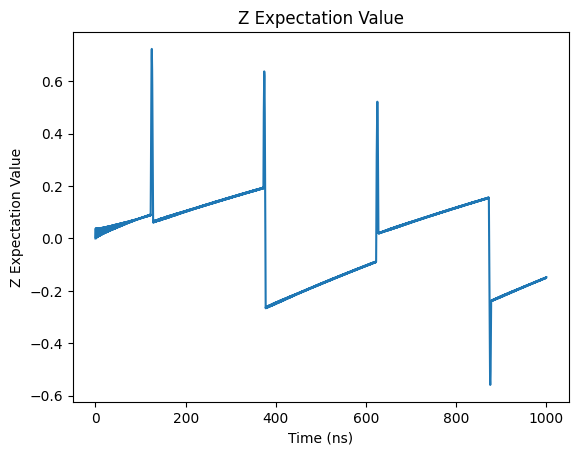

In [193]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

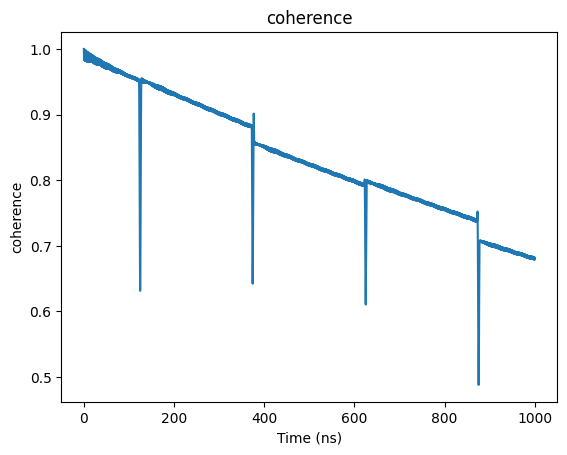

In [194]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

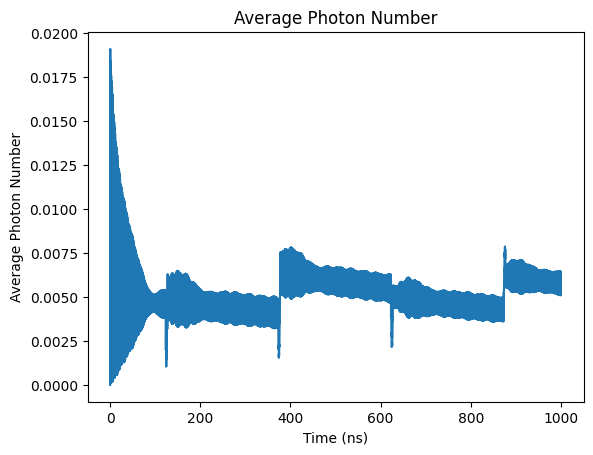

In [195]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

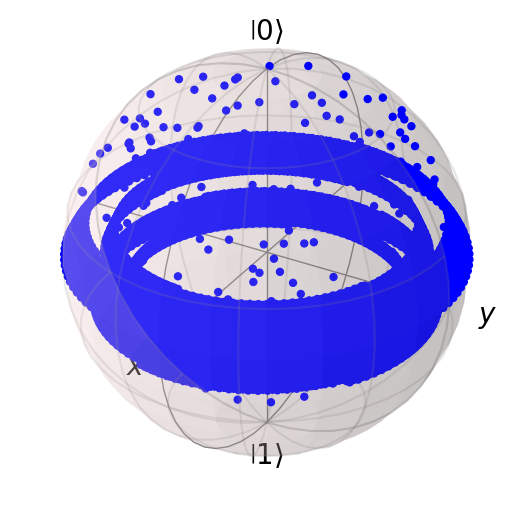

In [196]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [197]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY8

In [198]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005138973506821709


Text(0, 0.5, 'Z Expectation Value')

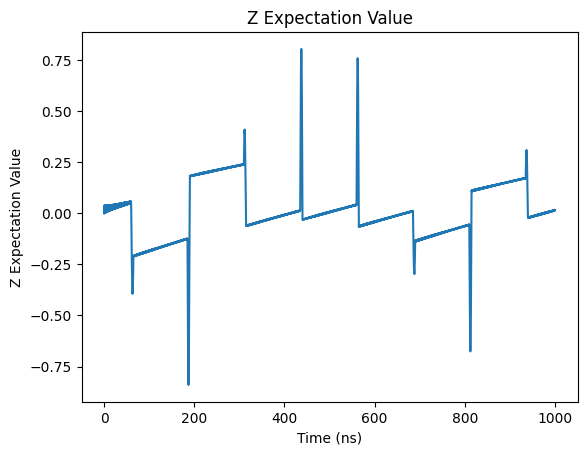

In [199]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

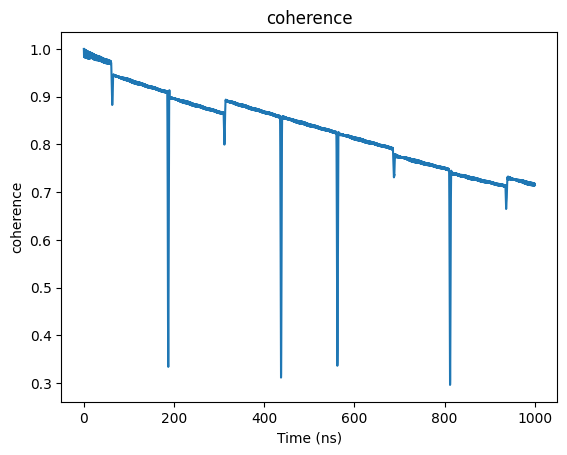

In [200]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

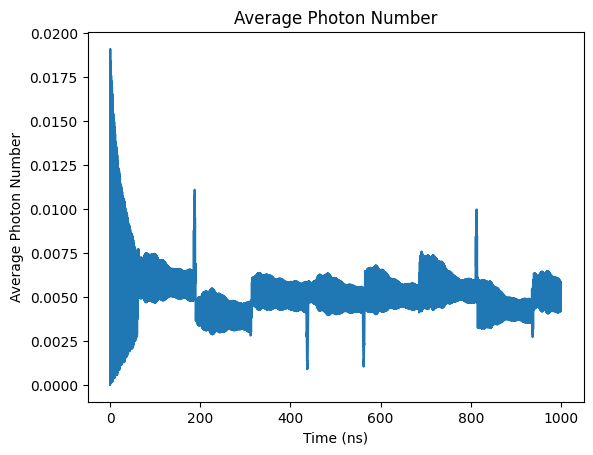

In [201]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

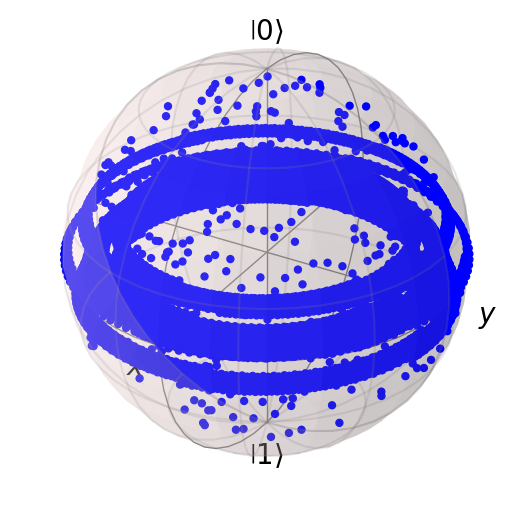

In [202]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [203]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## Print Coherence

In [204]:
coherence_list

[0.6793514544153385, 0.7140429999613148]

# Dynamical Decoupling Simulation

$ \omega_{qd} = \omega_q^b + \chi$

Evolution time 1000ns

In [205]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q + chi      # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 1000, 10000)
T_end_q = 1000

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.0002 * 2 * np.pi
B = 0.1 * 2 * np.pi

coherence_list = []

## Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=1)

In [ ]:
# Simulation

N_seq = 1

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=1)

In [ ]:
N_seq = 1


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY4

In [206]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005069971500935266


Text(0, 0.5, 'Z Expectation Value')

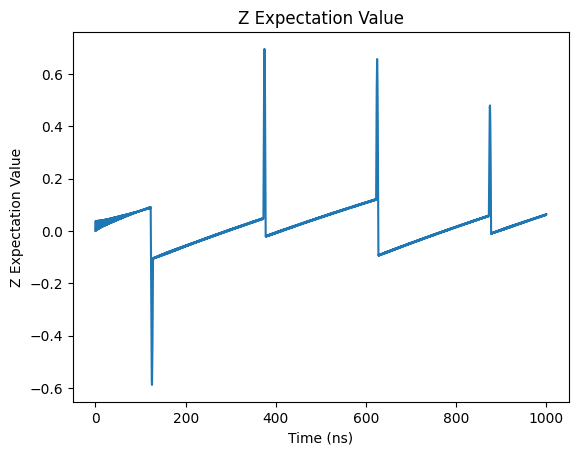

In [207]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

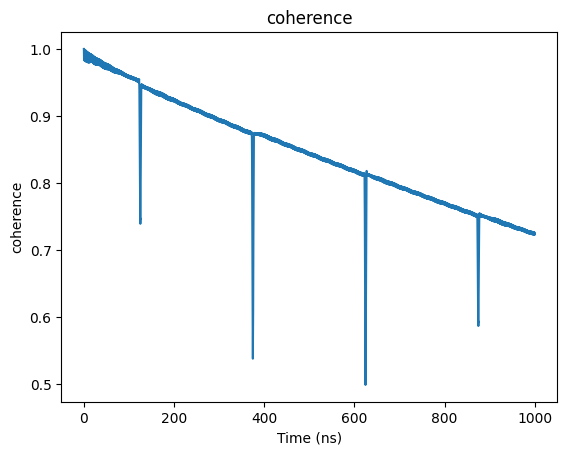

In [208]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

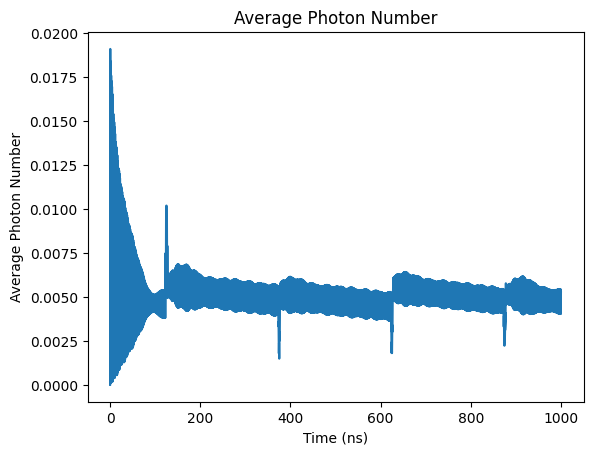

In [209]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

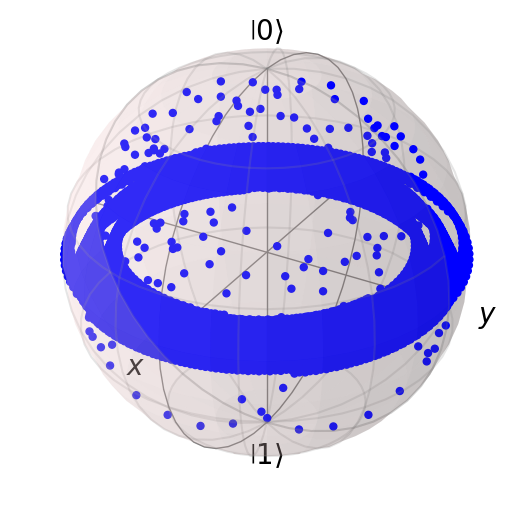

In [210]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [211]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY8

In [212]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005138112668178924


Text(0, 0.5, 'Z Expectation Value')

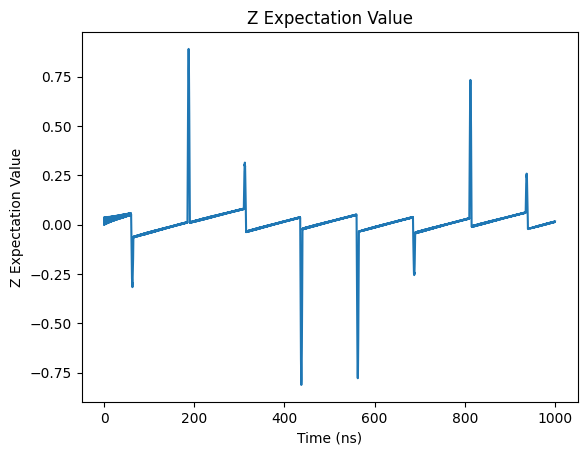

In [213]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

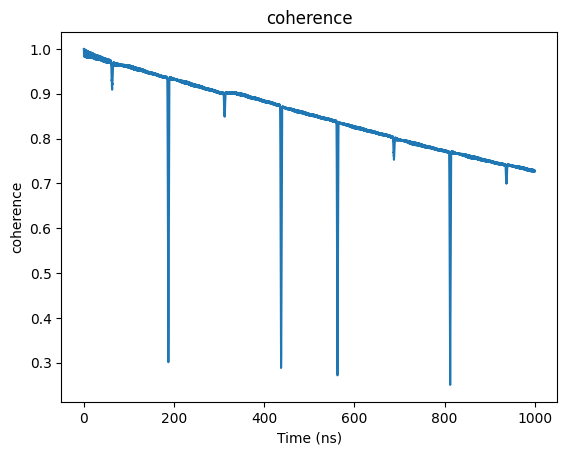

In [214]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

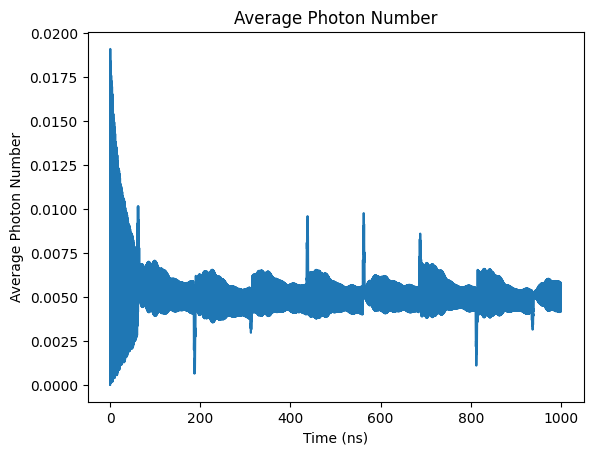

In [215]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

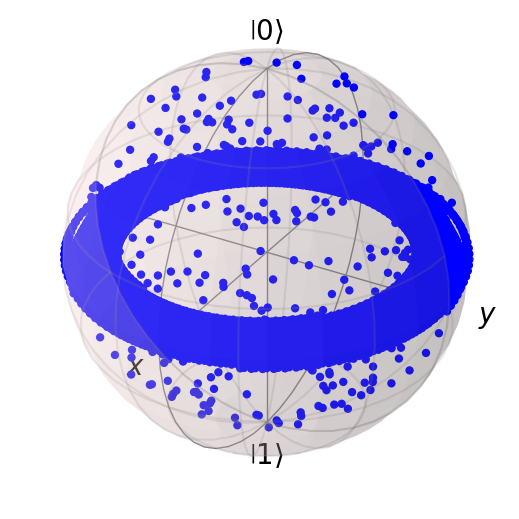

In [216]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [217]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## Print Coherence

In [218]:
coherence_list

[0.7230928778449953, 0.7262253768692384]

# Dynamical Decoupling Simulation

$ \omega_{qd} = \omega_q^b + 2n\chi$

Evolution time 1000ns

In [219]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q + chi + 2*0.005*chi     # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 1000, 10000)
T_end_q = 1000

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.0002 * 2 * np.pi
B = 0.1 * 2 * np.pi

coherence_list = []

## Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

Measured $ T_1 = 1.6169 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=1)

In [ ]:
# Simulation

N_seq = 1

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=1)

In [ ]:
N_seq = 1


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=2)

In [ ]:
N_seq = 2


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=4)

In [ ]:
N_seq = 4


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY4

In [220]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005077012723629808


Text(0, 0.5, 'Z Expectation Value')

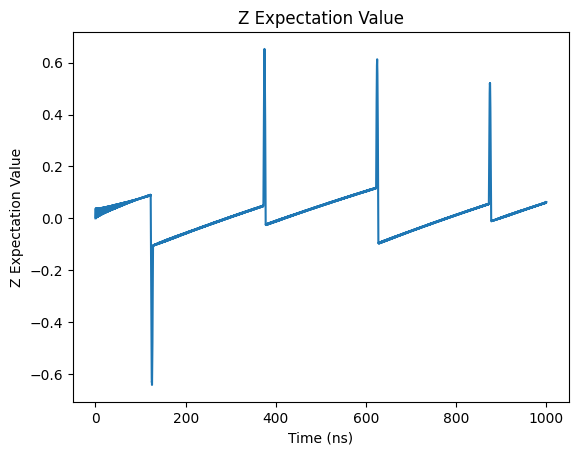

In [221]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

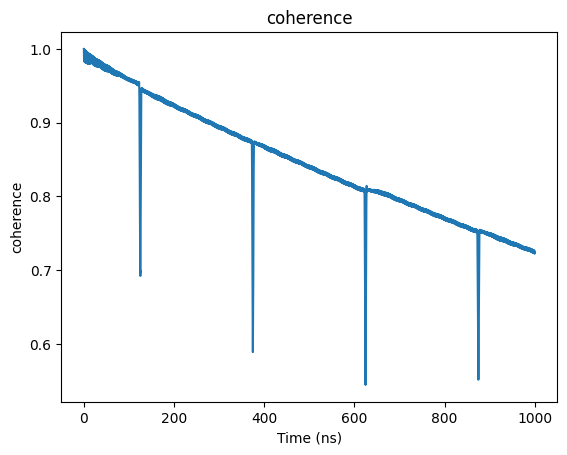

In [222]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

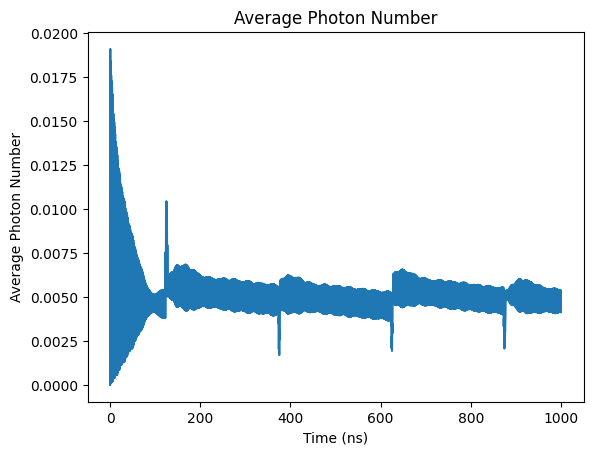

In [223]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

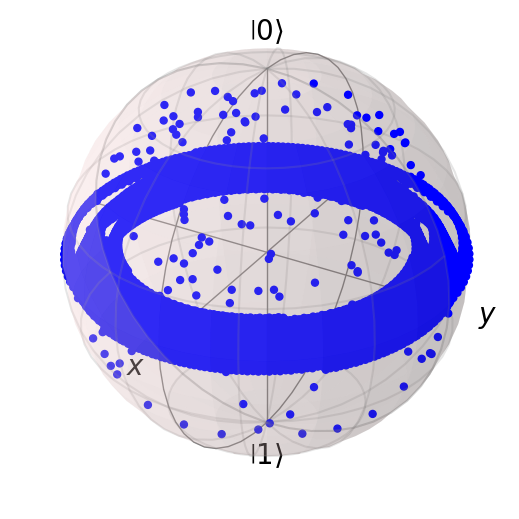

In [224]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [225]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=8)

In [ ]:
N_seq = 8


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY8

In [226]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.005138006288723534


Text(0, 0.5, 'Z Expectation Value')

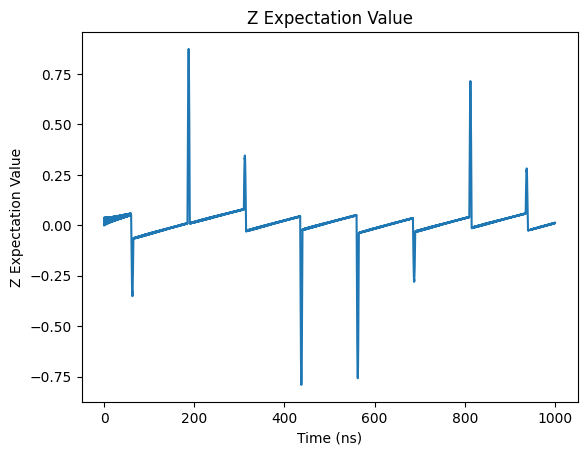

In [227]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

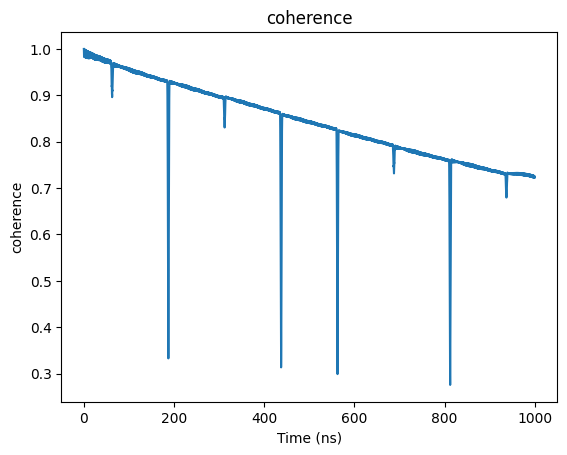

In [228]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

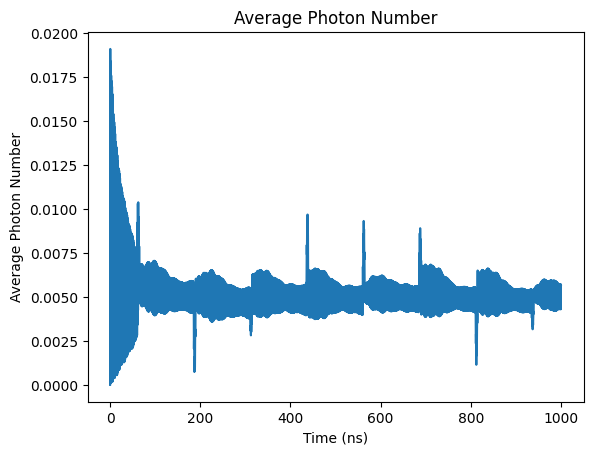

In [229]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

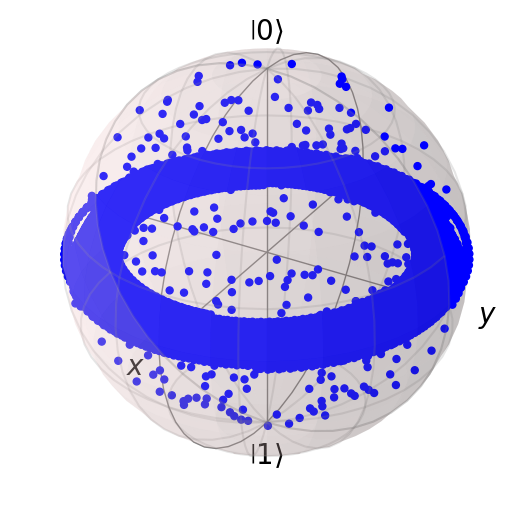

In [230]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [231]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CP (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## CPMG (N=16)

In [ ]:
N_seq = 16


# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
coherence_list.append(2*np.abs(result.expect[3][-1]))

## Print Coherence

In [232]:
coherence_list

[0.7237160554633462, 0.7231386762032895]